/home/shkim/anaconda3/envs/vit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


odict_keys(['cls_token', 'pos_embed', 'reg_token', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.modules_list.0.norm1.weight', 'blocks.modules_list.0.norm1.bias', 'blocks.modules_list.0.attn.qkv.weight', 'blocks.modules_list.0.attn.qkv.bias', 'blocks.modules_list.0.attn.proj.weight', 'blocks.modules_list.0.attn.proj.bias', 'blocks.modules_list.0.norm2.weight', 'blocks.modules_list.0.norm2.bias', 'blocks.modules_list.0.mlp.fc1.weight', 'blocks.modules_list.0.mlp.fc1.bias', 'blocks.modules_list.0.mlp.fc2.weight', 'blocks.modules_list.0.mlp.fc2.bias', 'blocks.modules_list.1.norm1.weight', 'blocks.modules_list.1.norm1.bias', 'blocks.modules_list.1.attn.qkv.weight', 'blocks.modules_list.1.attn.qkv.bias', 'blocks.modules_list.1.attn.proj.weight', 'blocks.modules_list.1.attn.proj.bias', 'blocks.modules_list.1.norm2.weight', 'blocks.modules_list.1.norm2.bias', 'blocks.modules_list.1.mlp.fc1.weight', 'blocks.modules_list.1.mlp.fc1.bias', 'blocks.modules_list.1.mlp.fc2.weight', 'bl

/tmp/ipykernel_1071548/3097400556.py:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


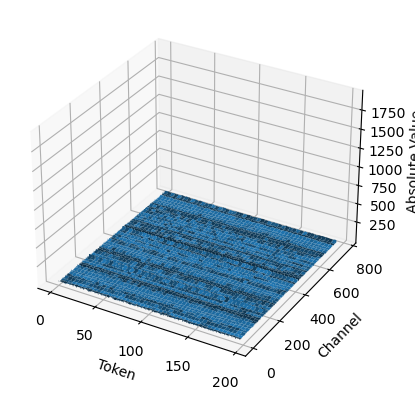

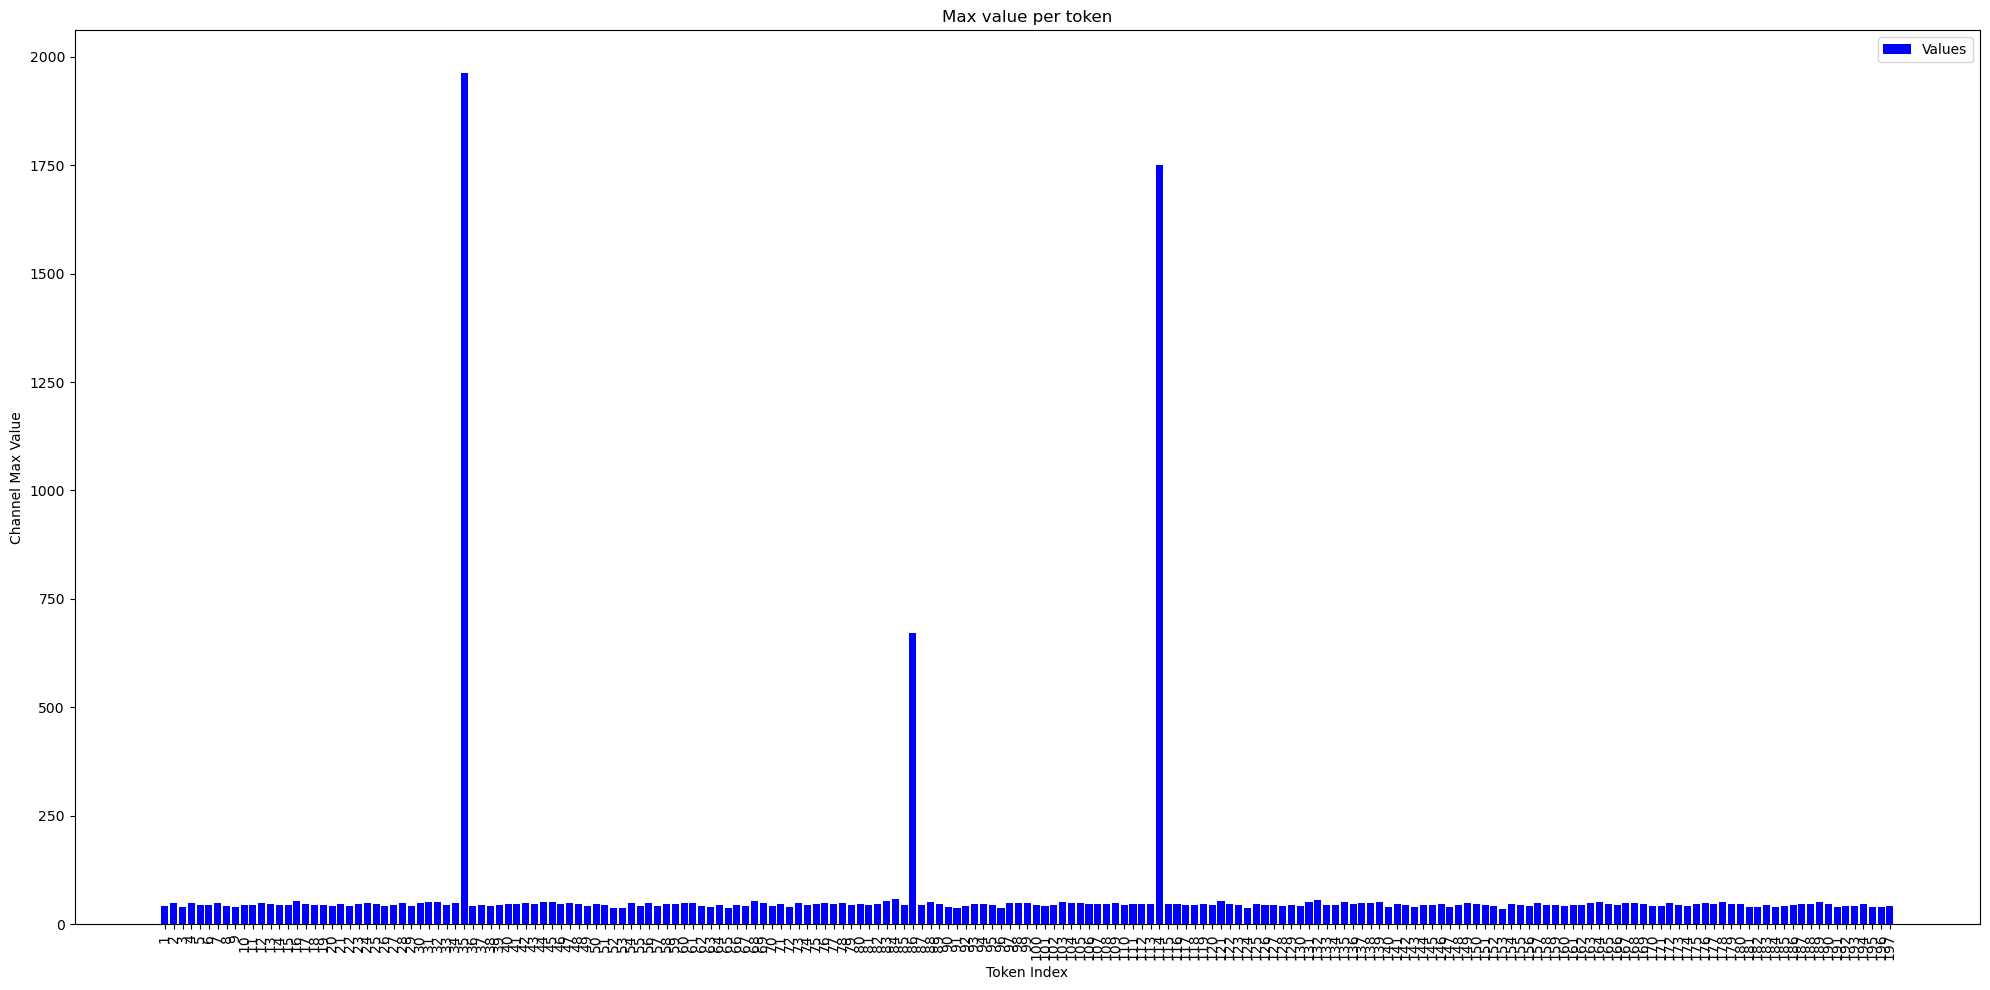

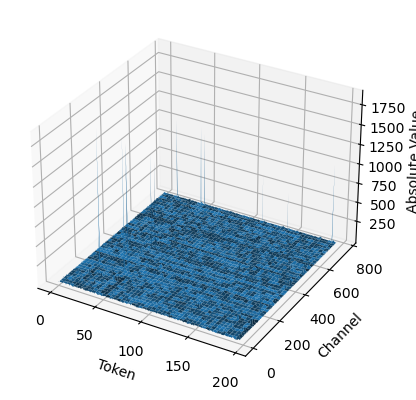

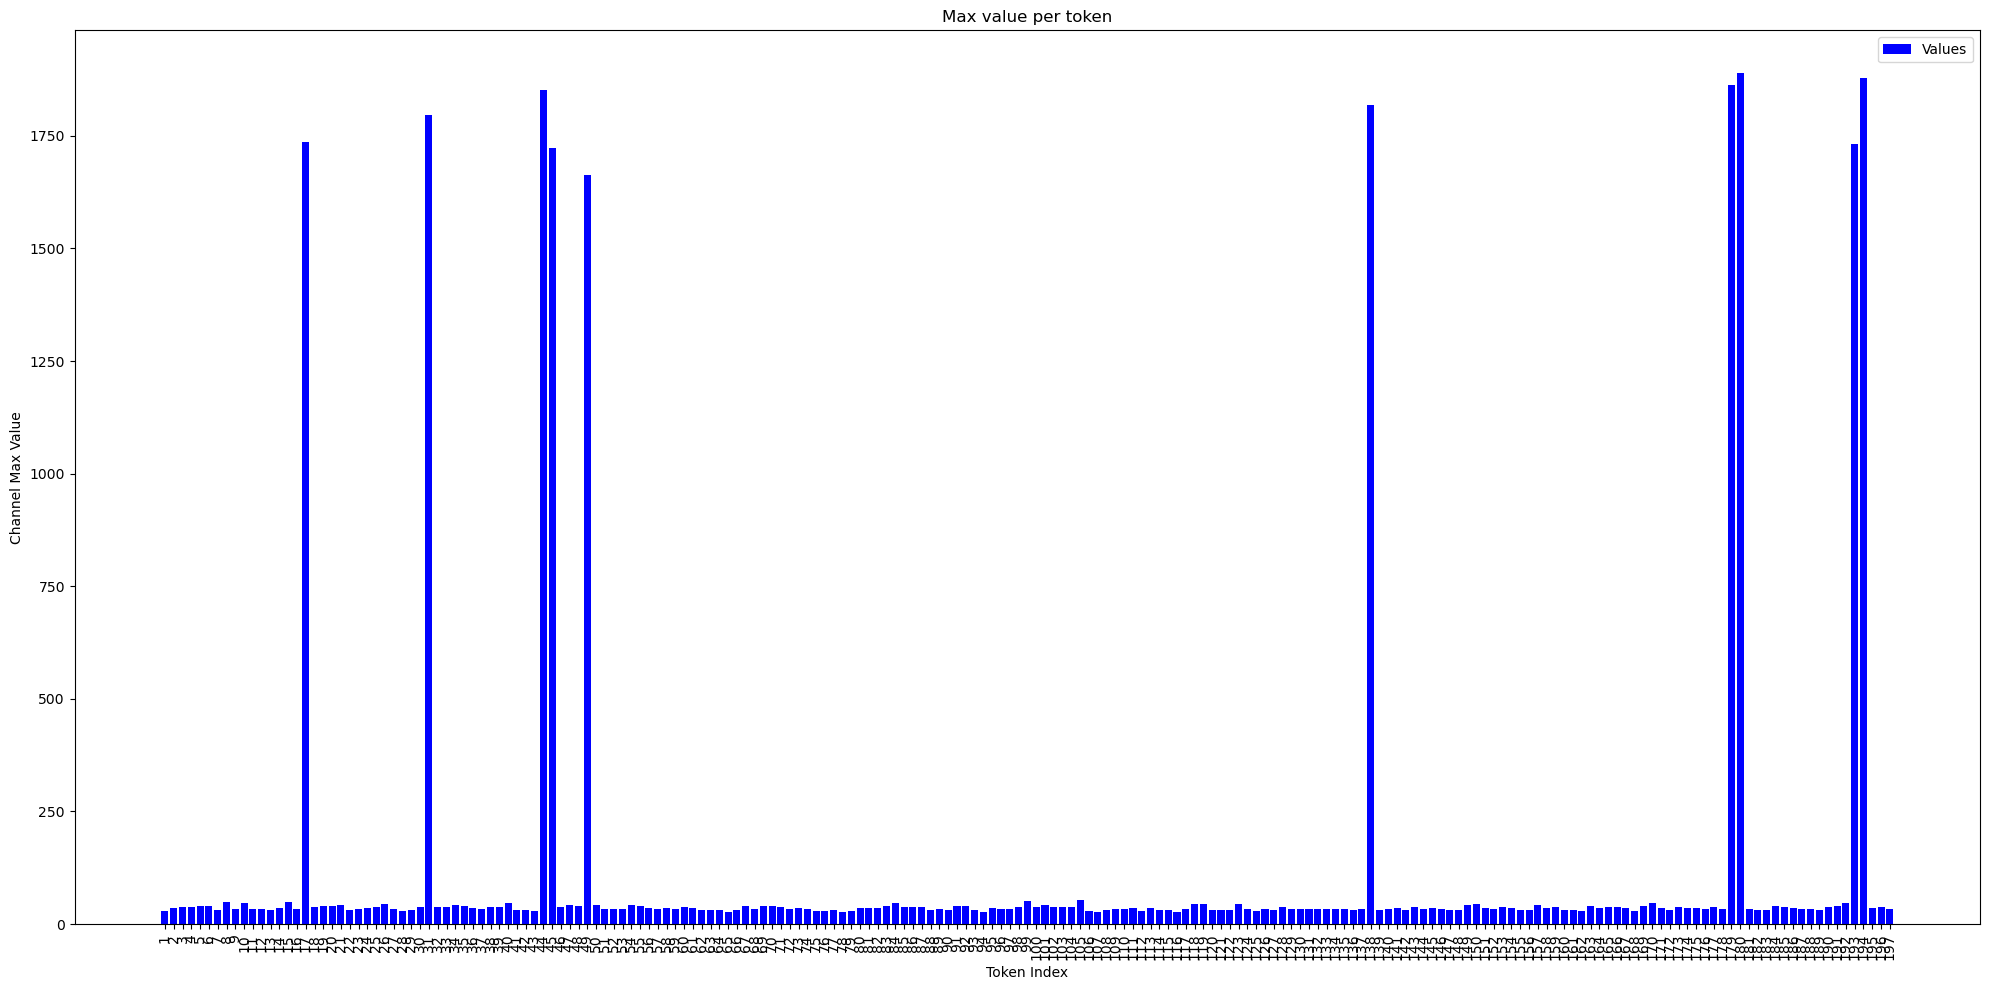

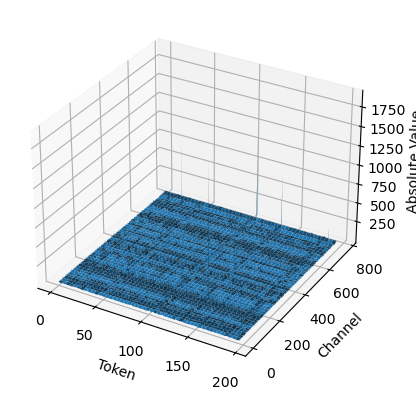

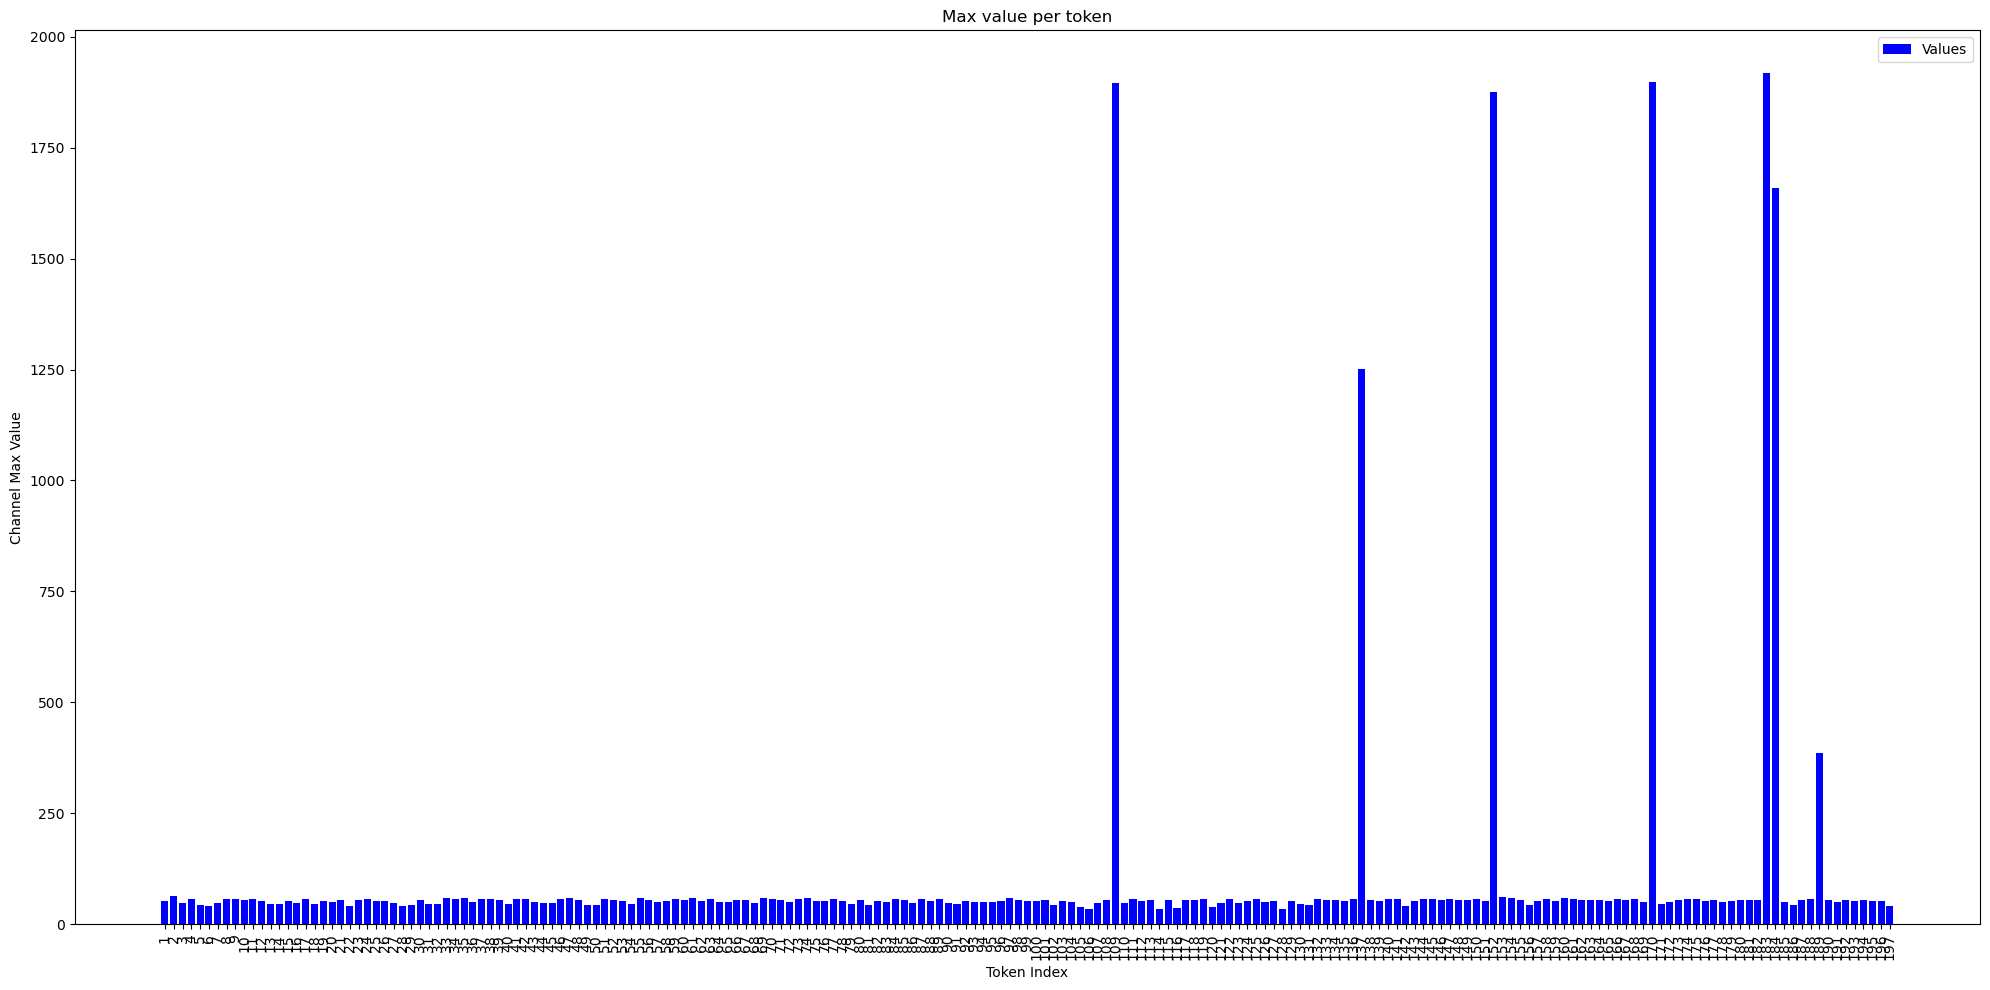

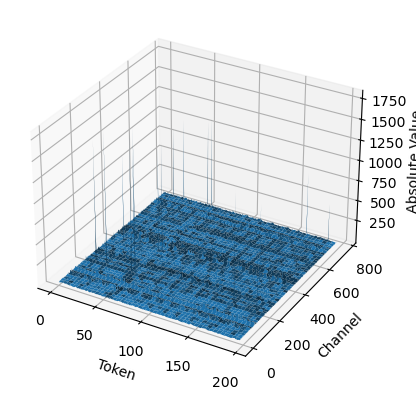

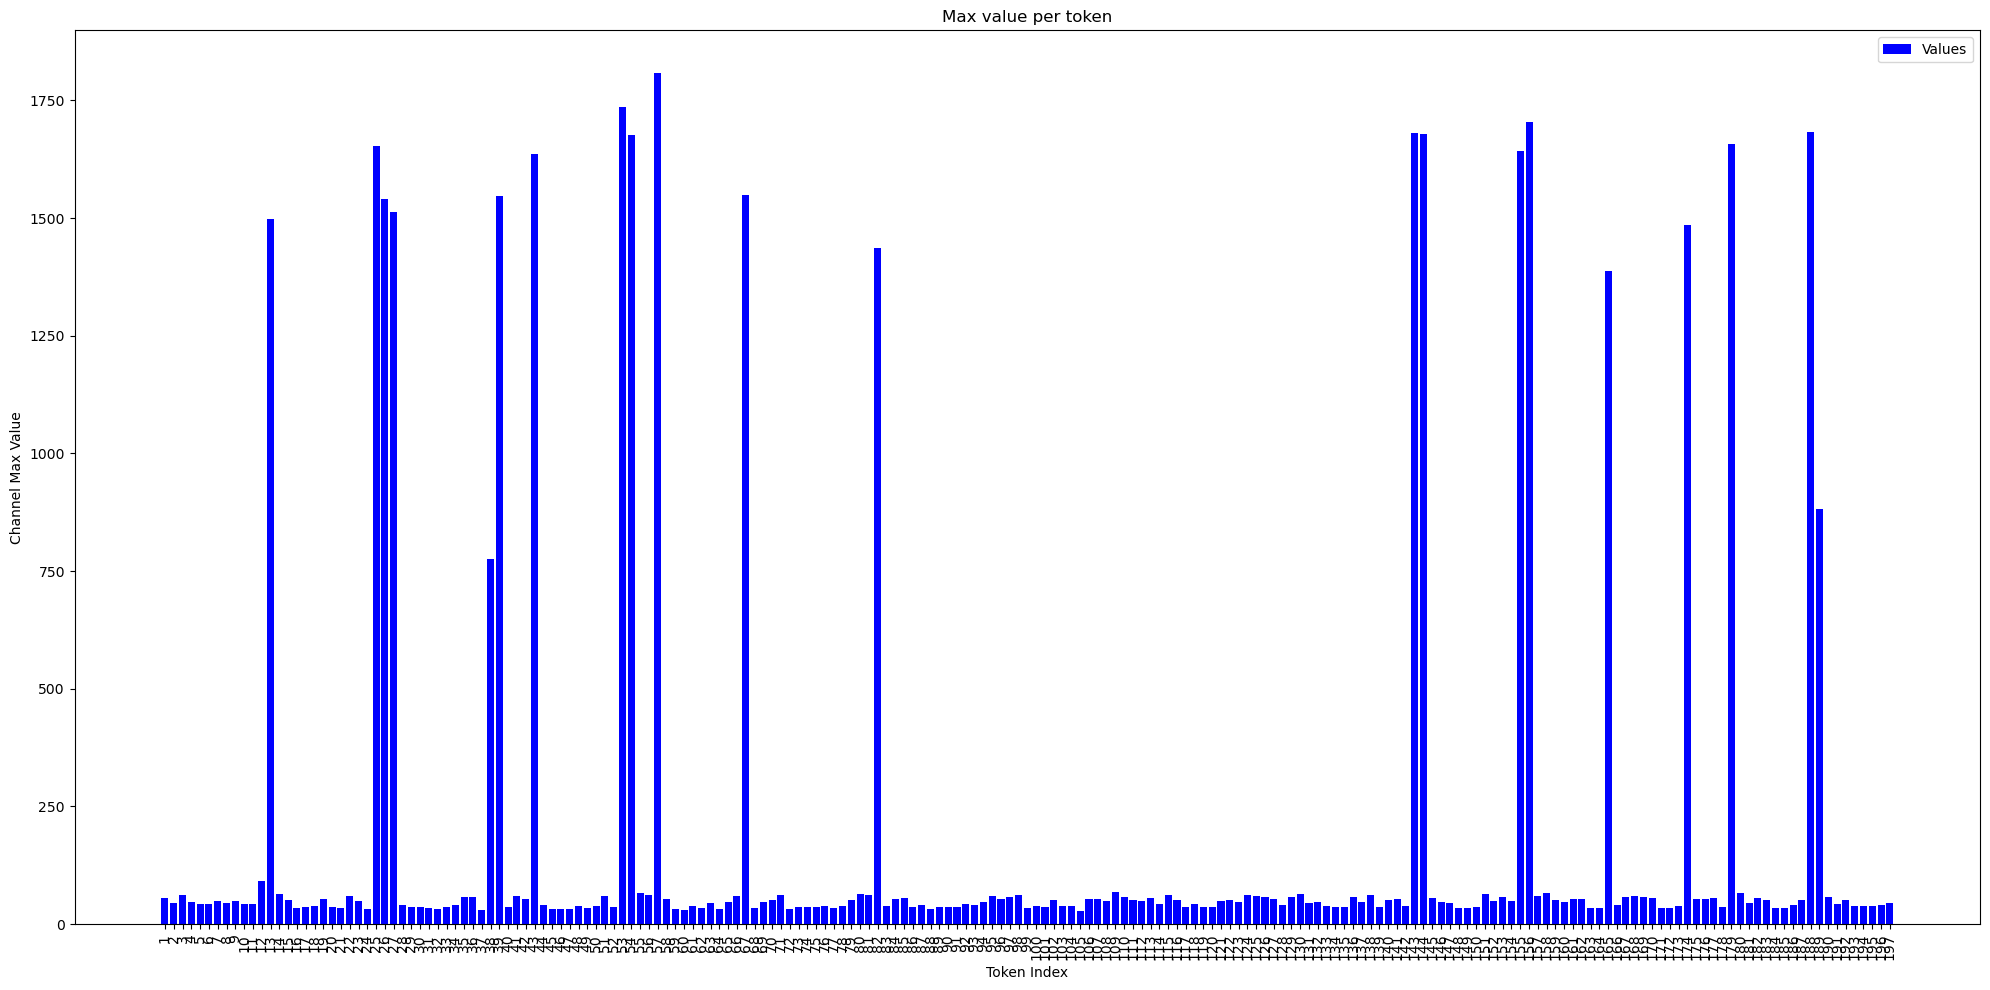

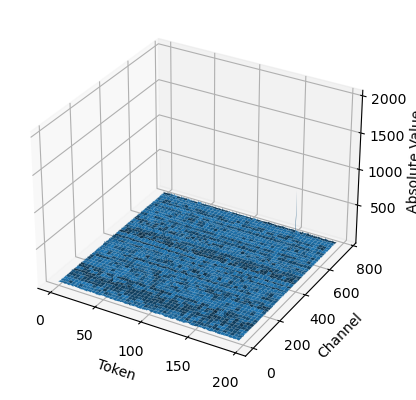

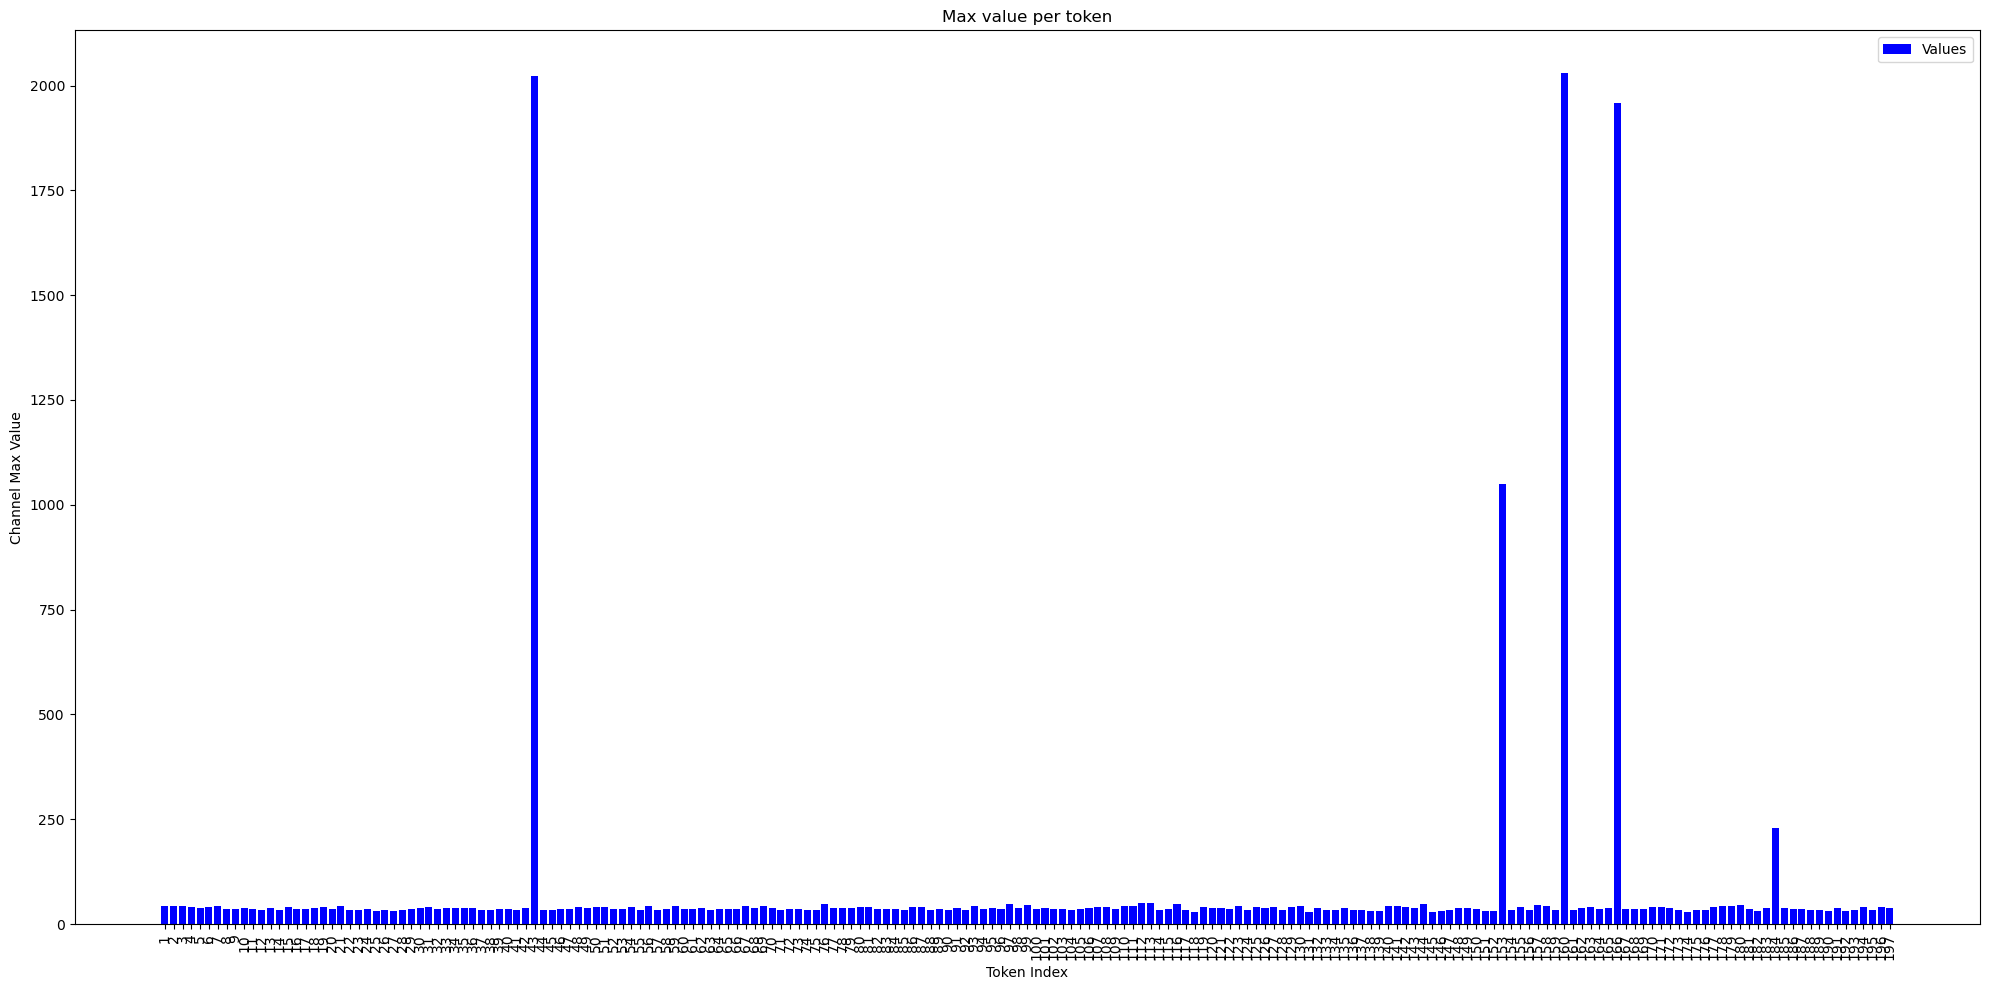

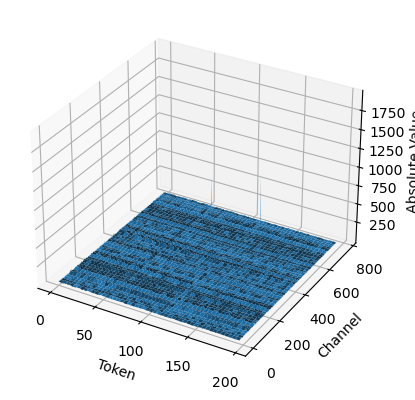

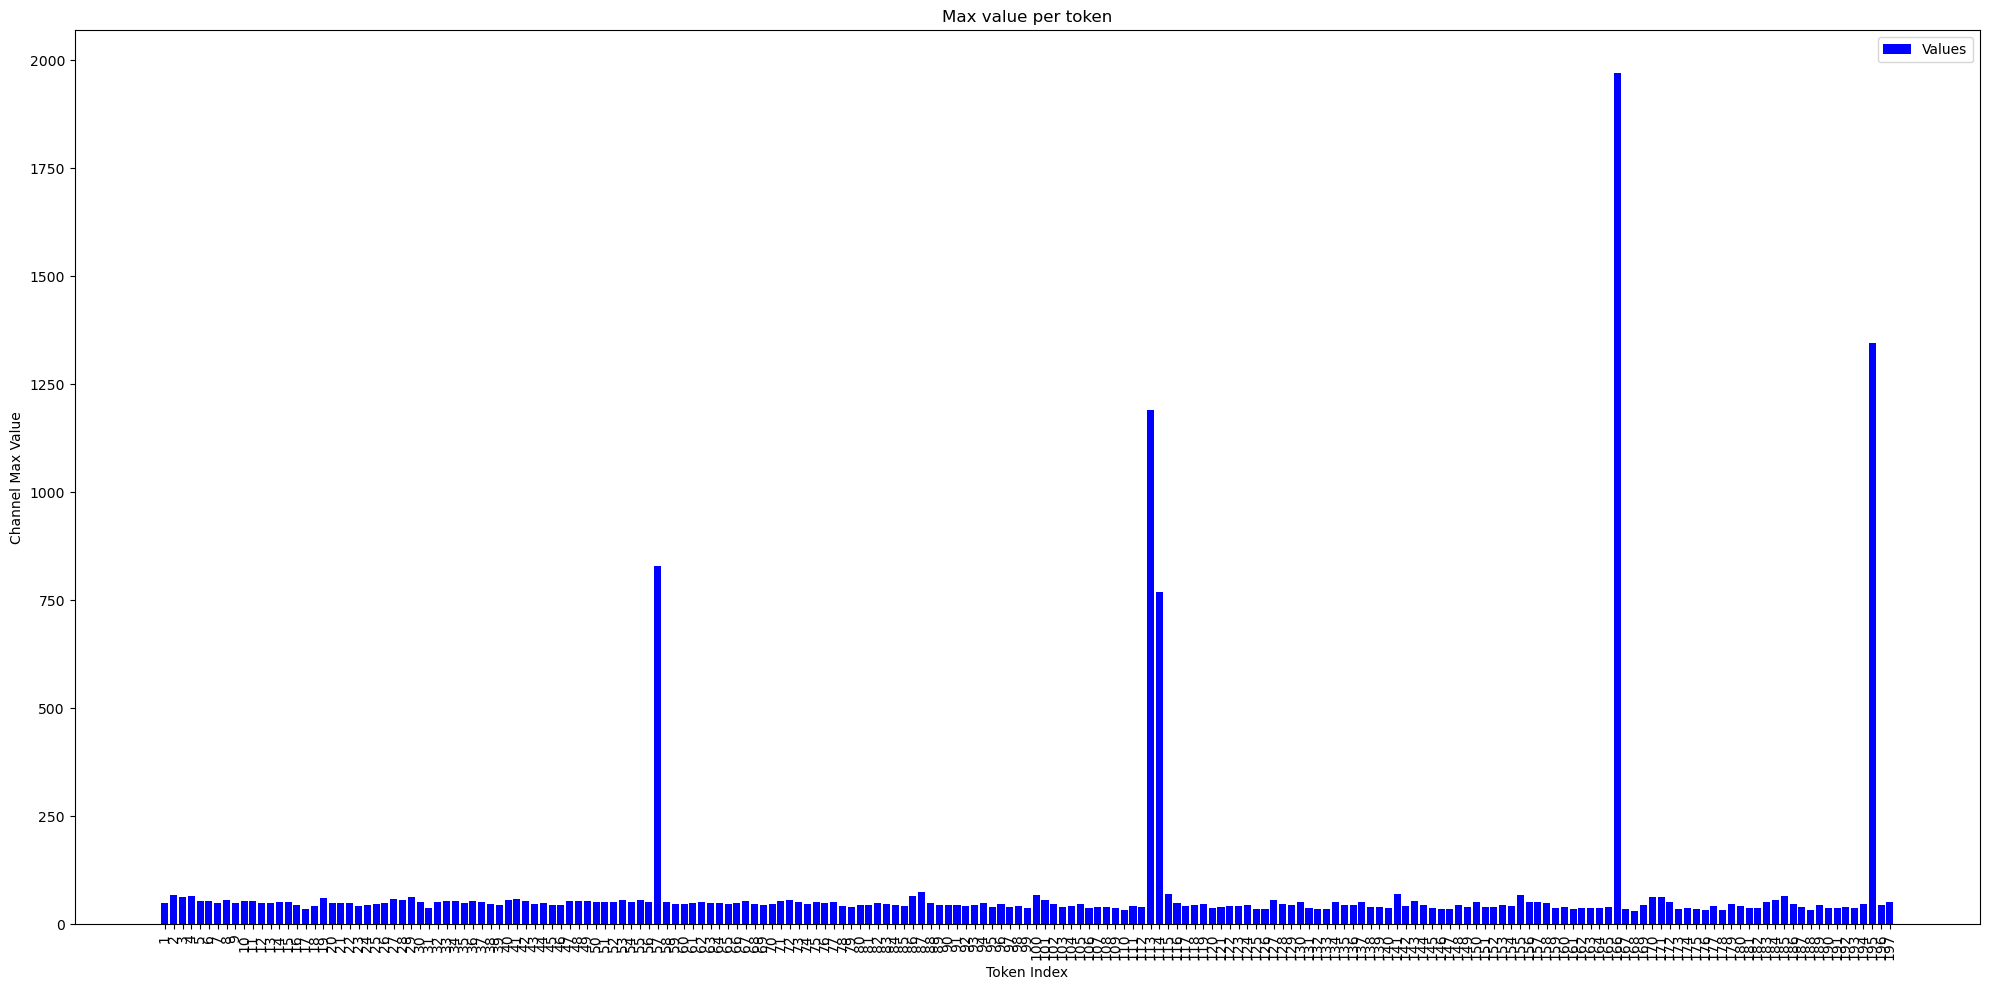

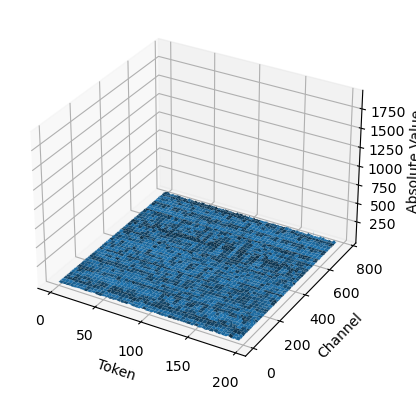

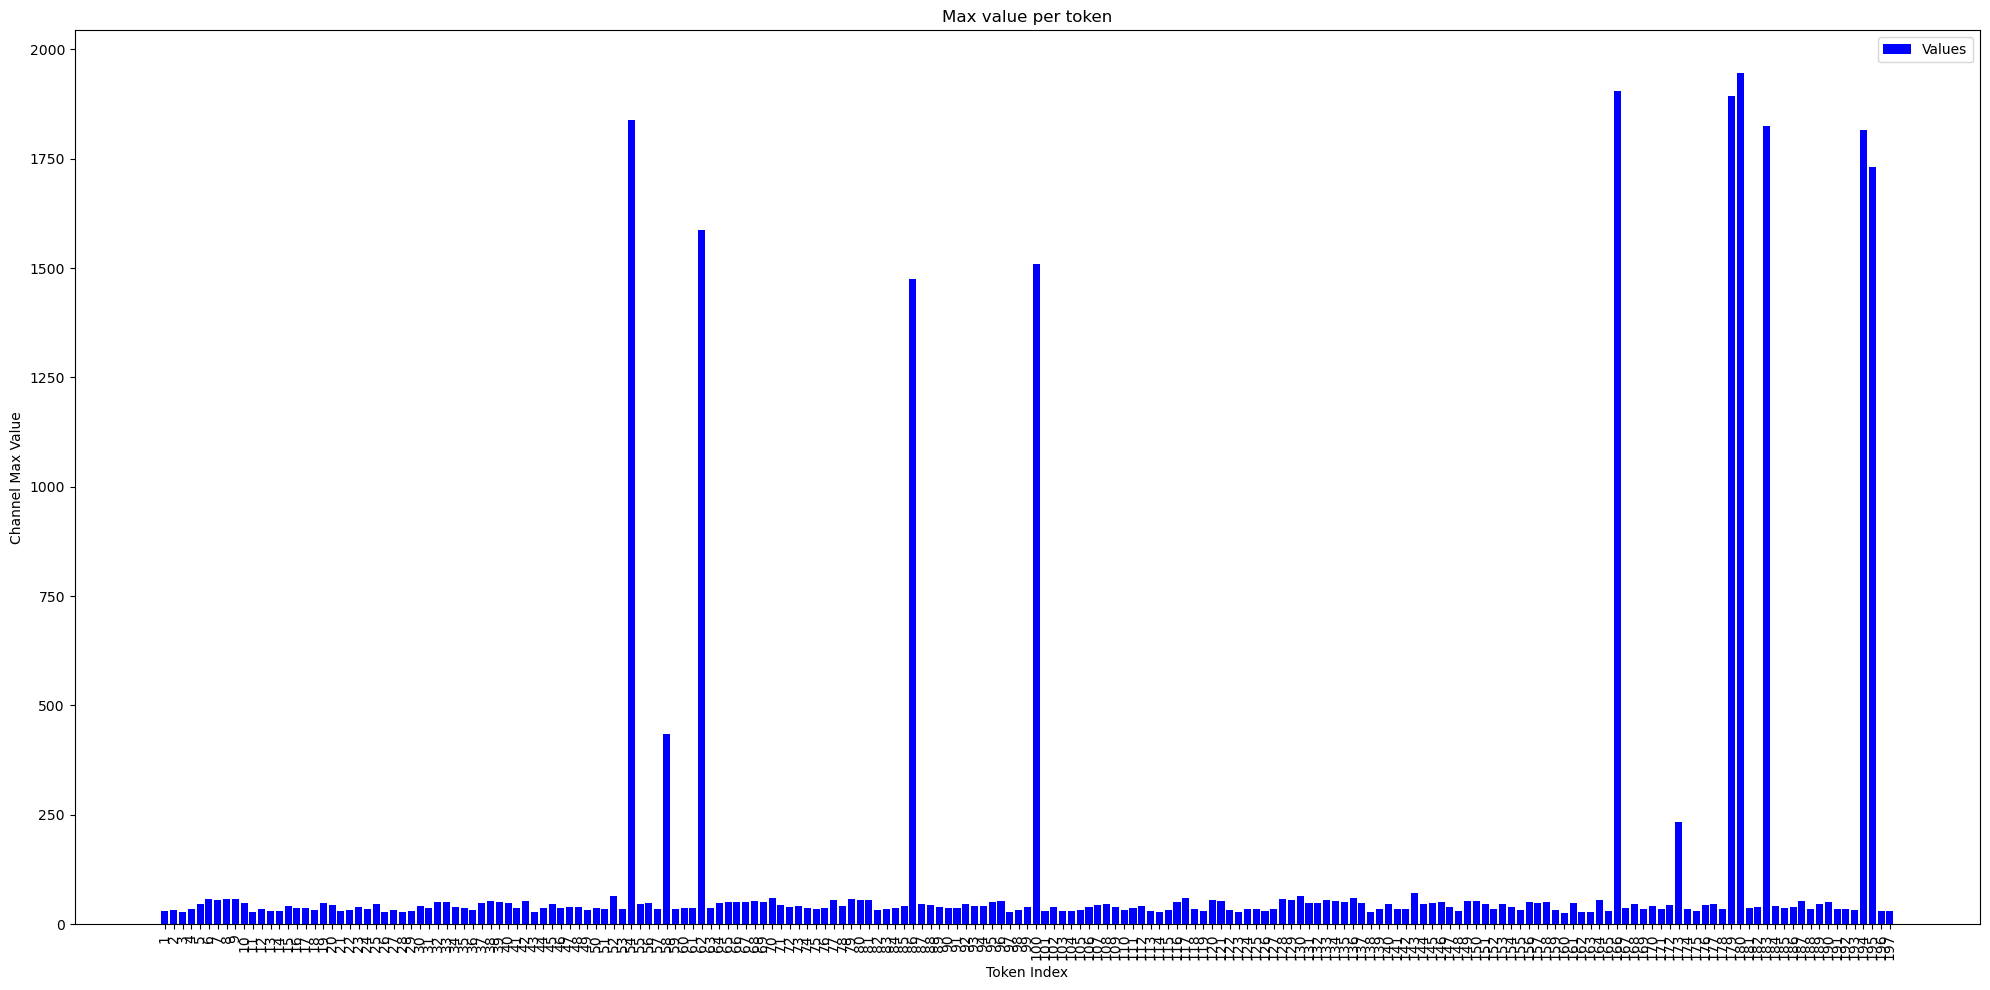

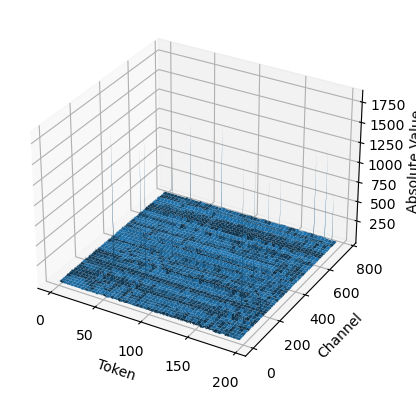

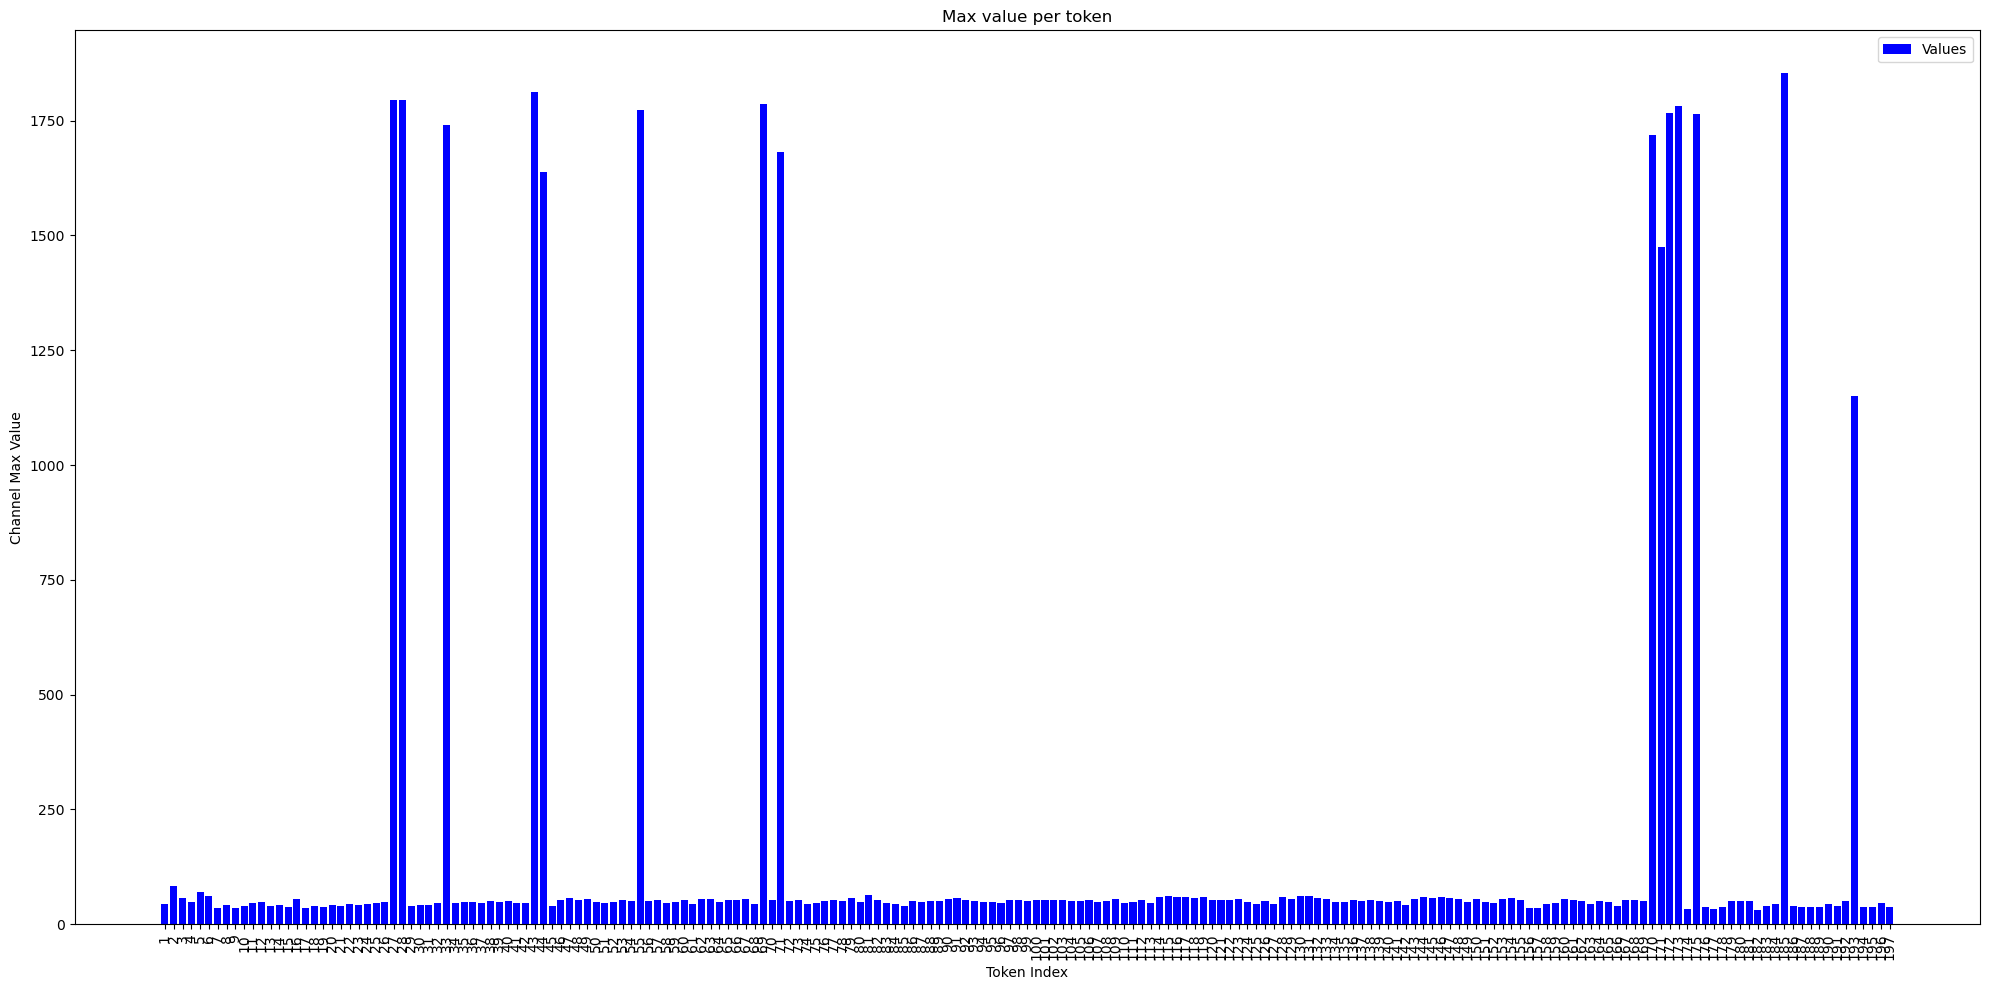

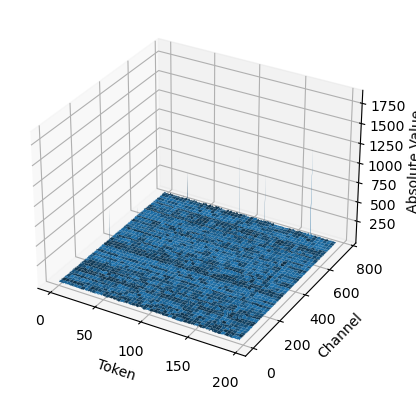

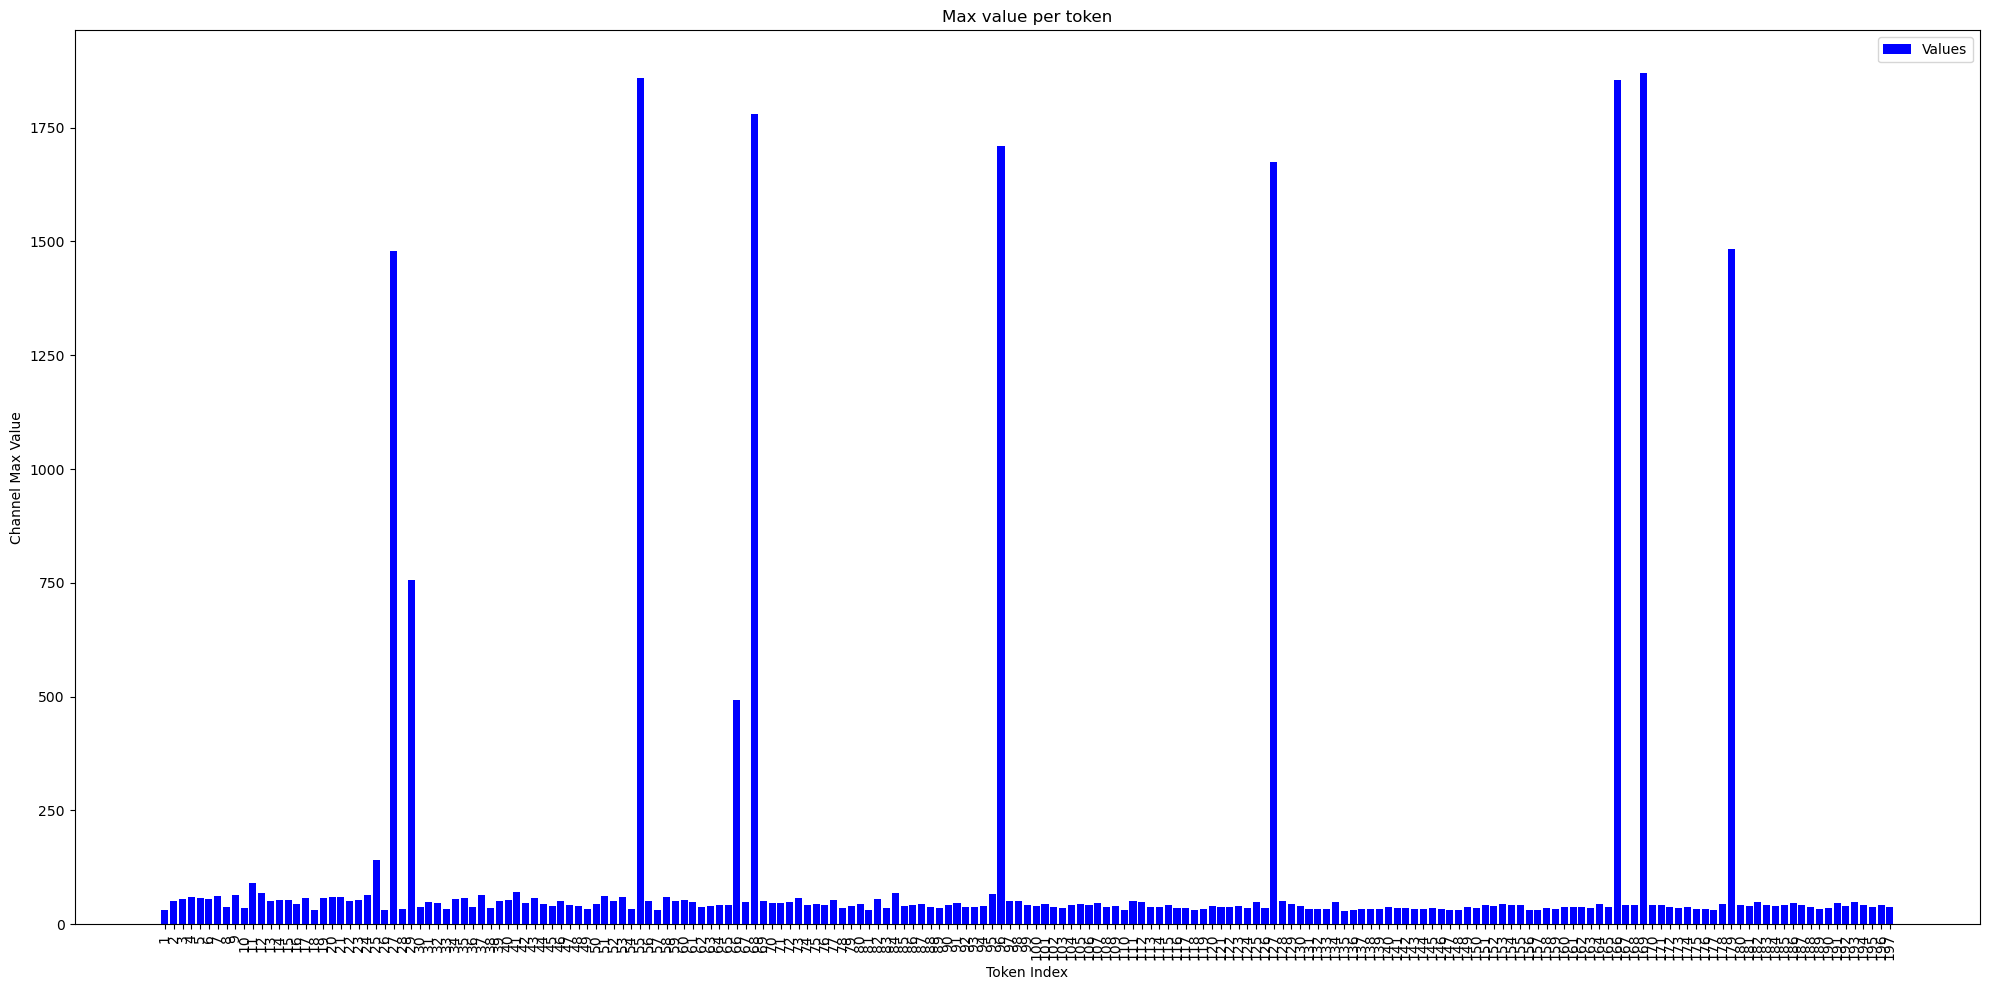

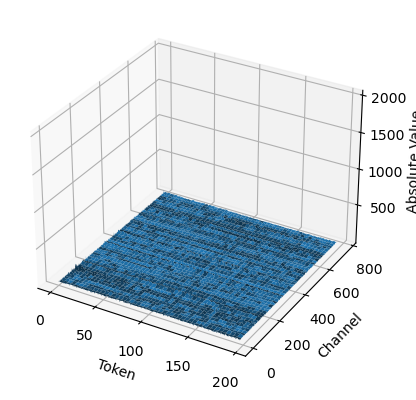

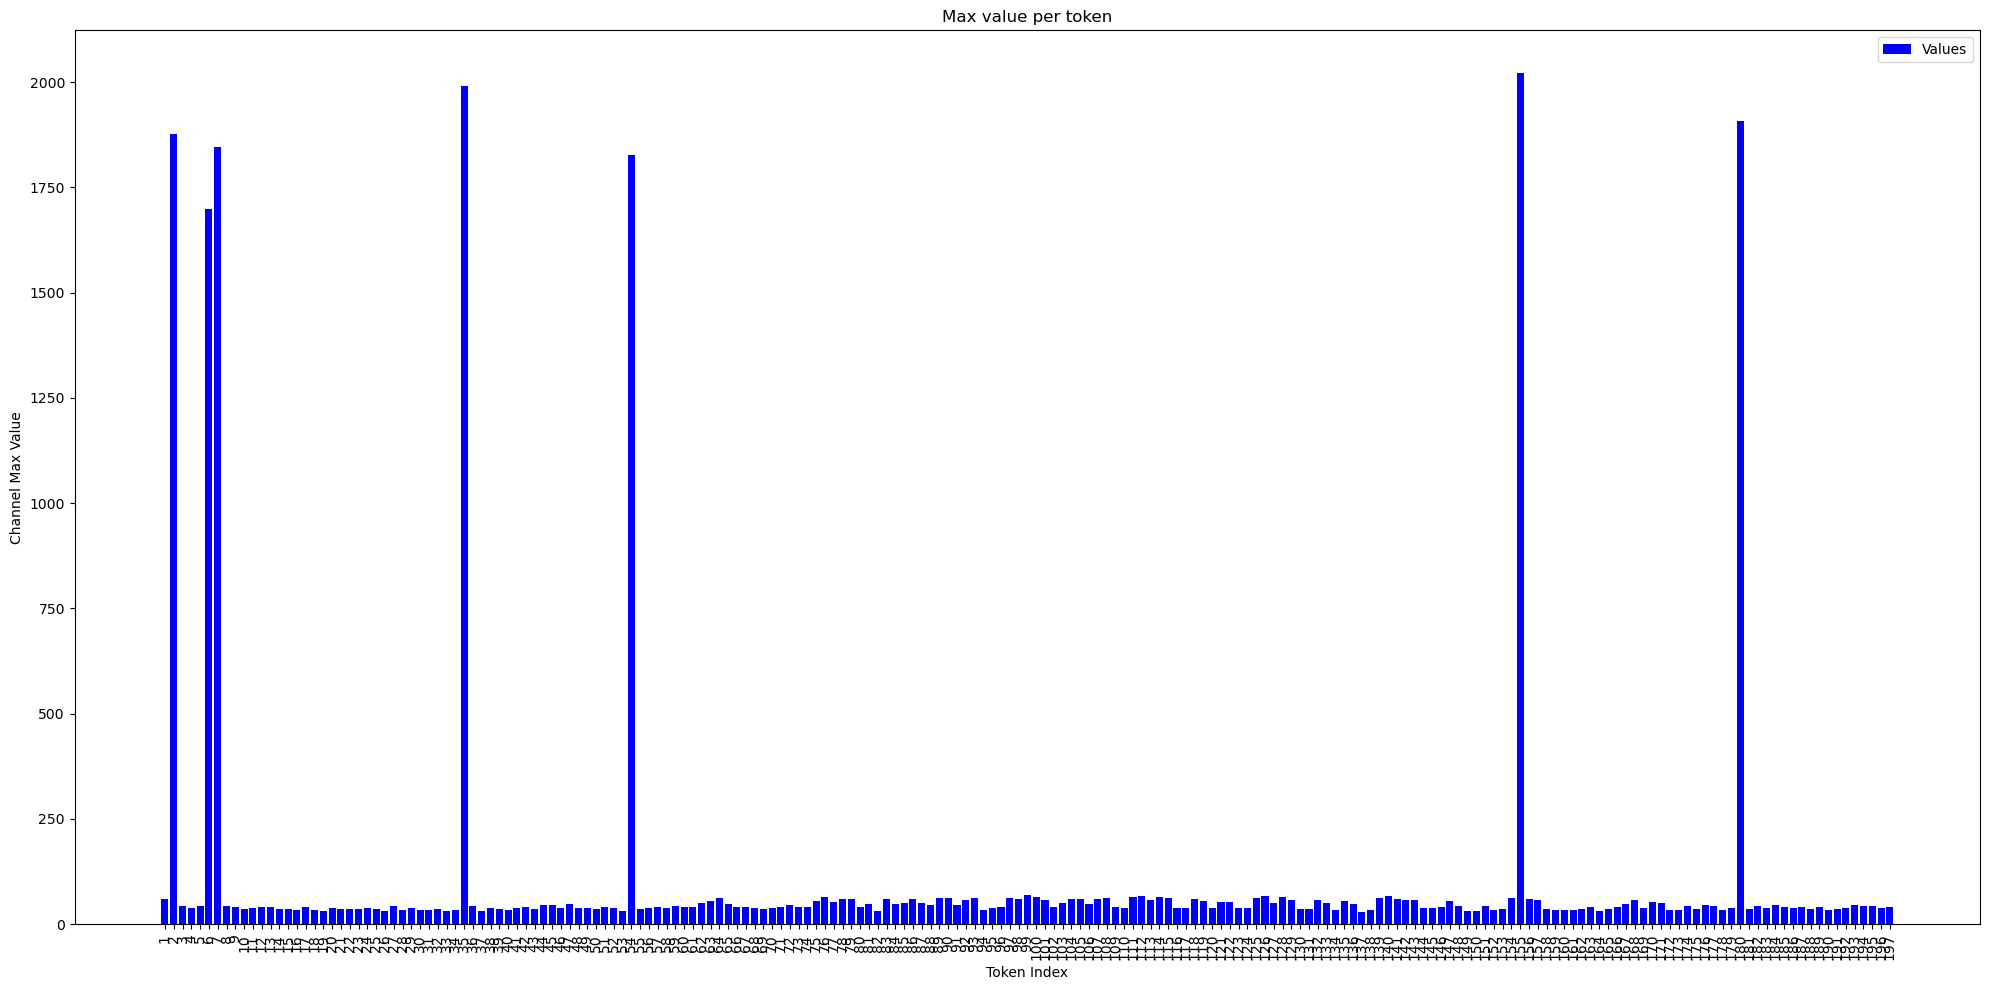

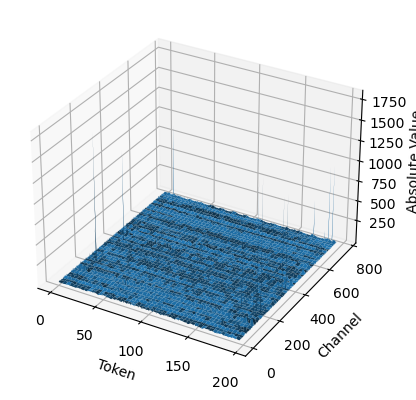

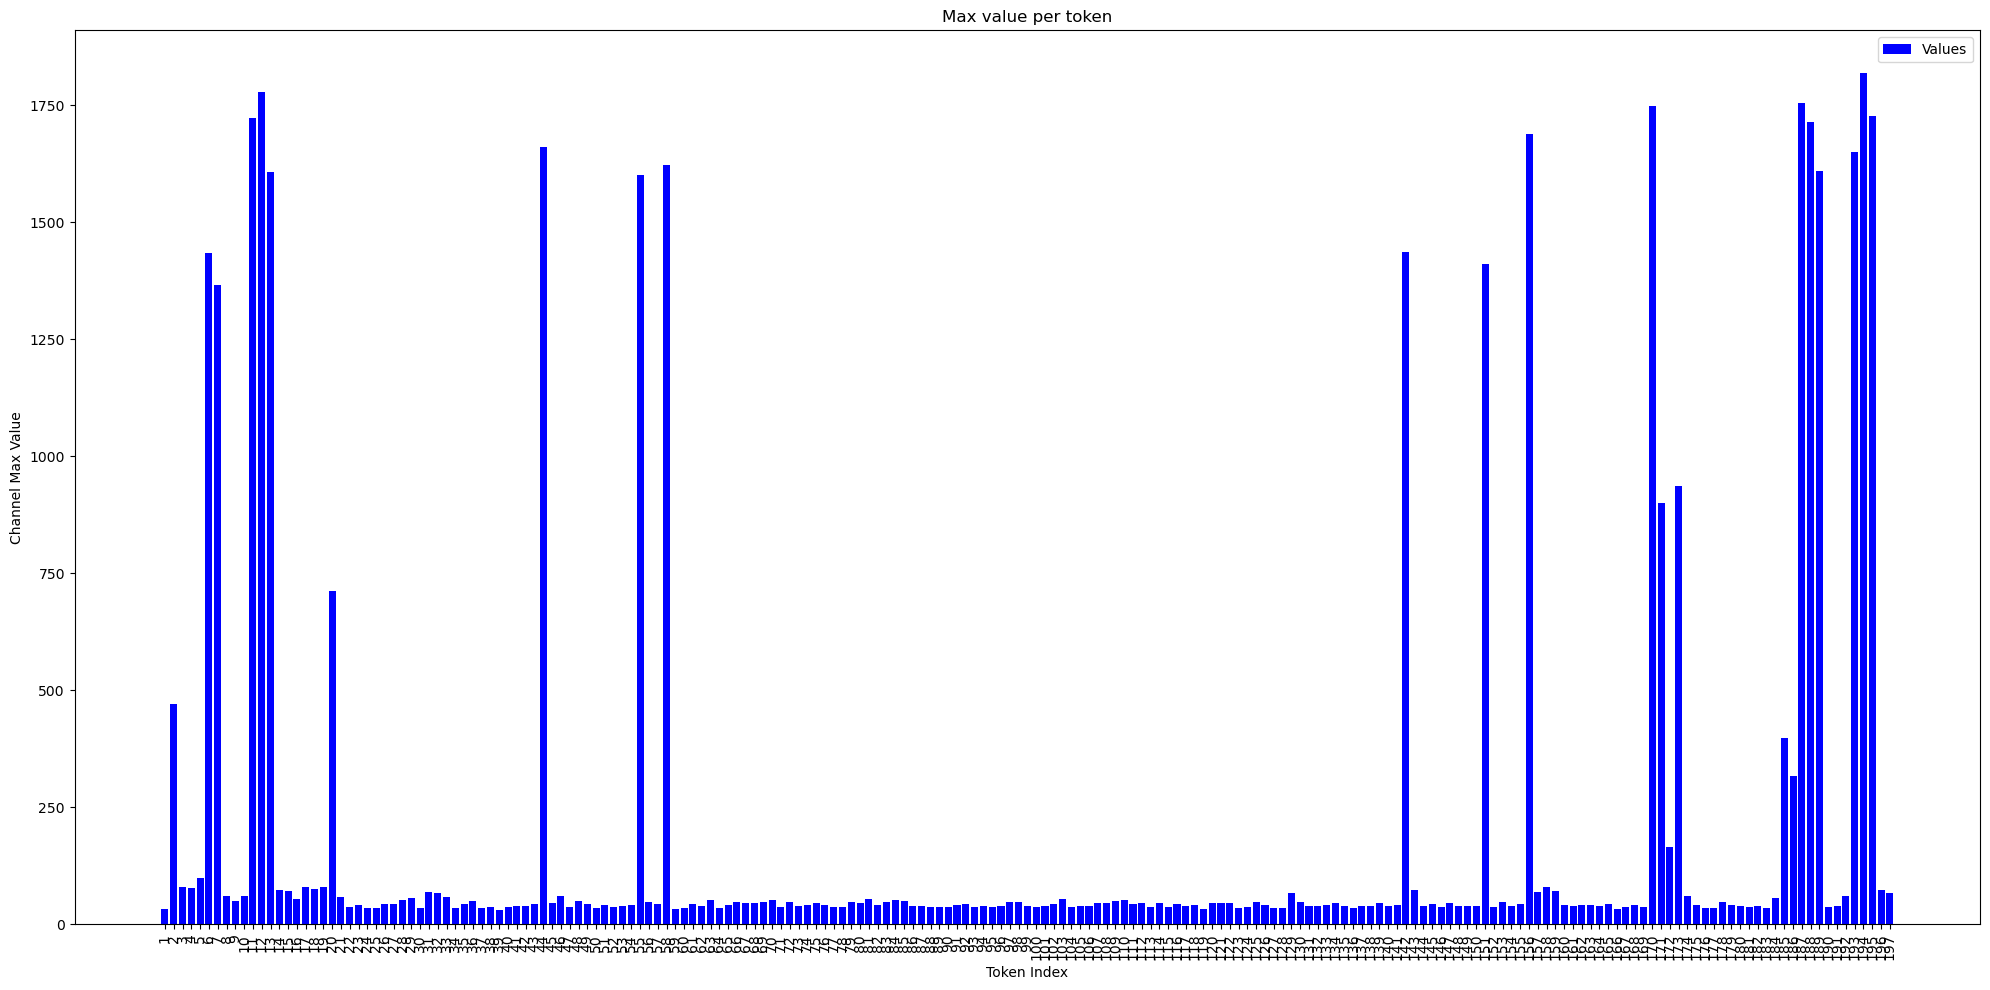

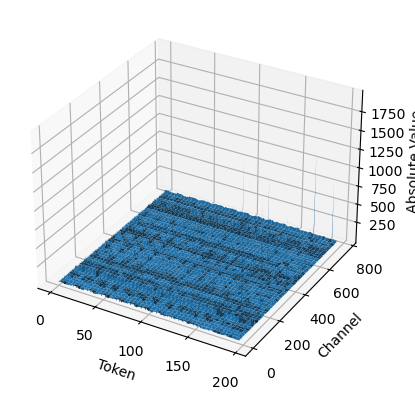

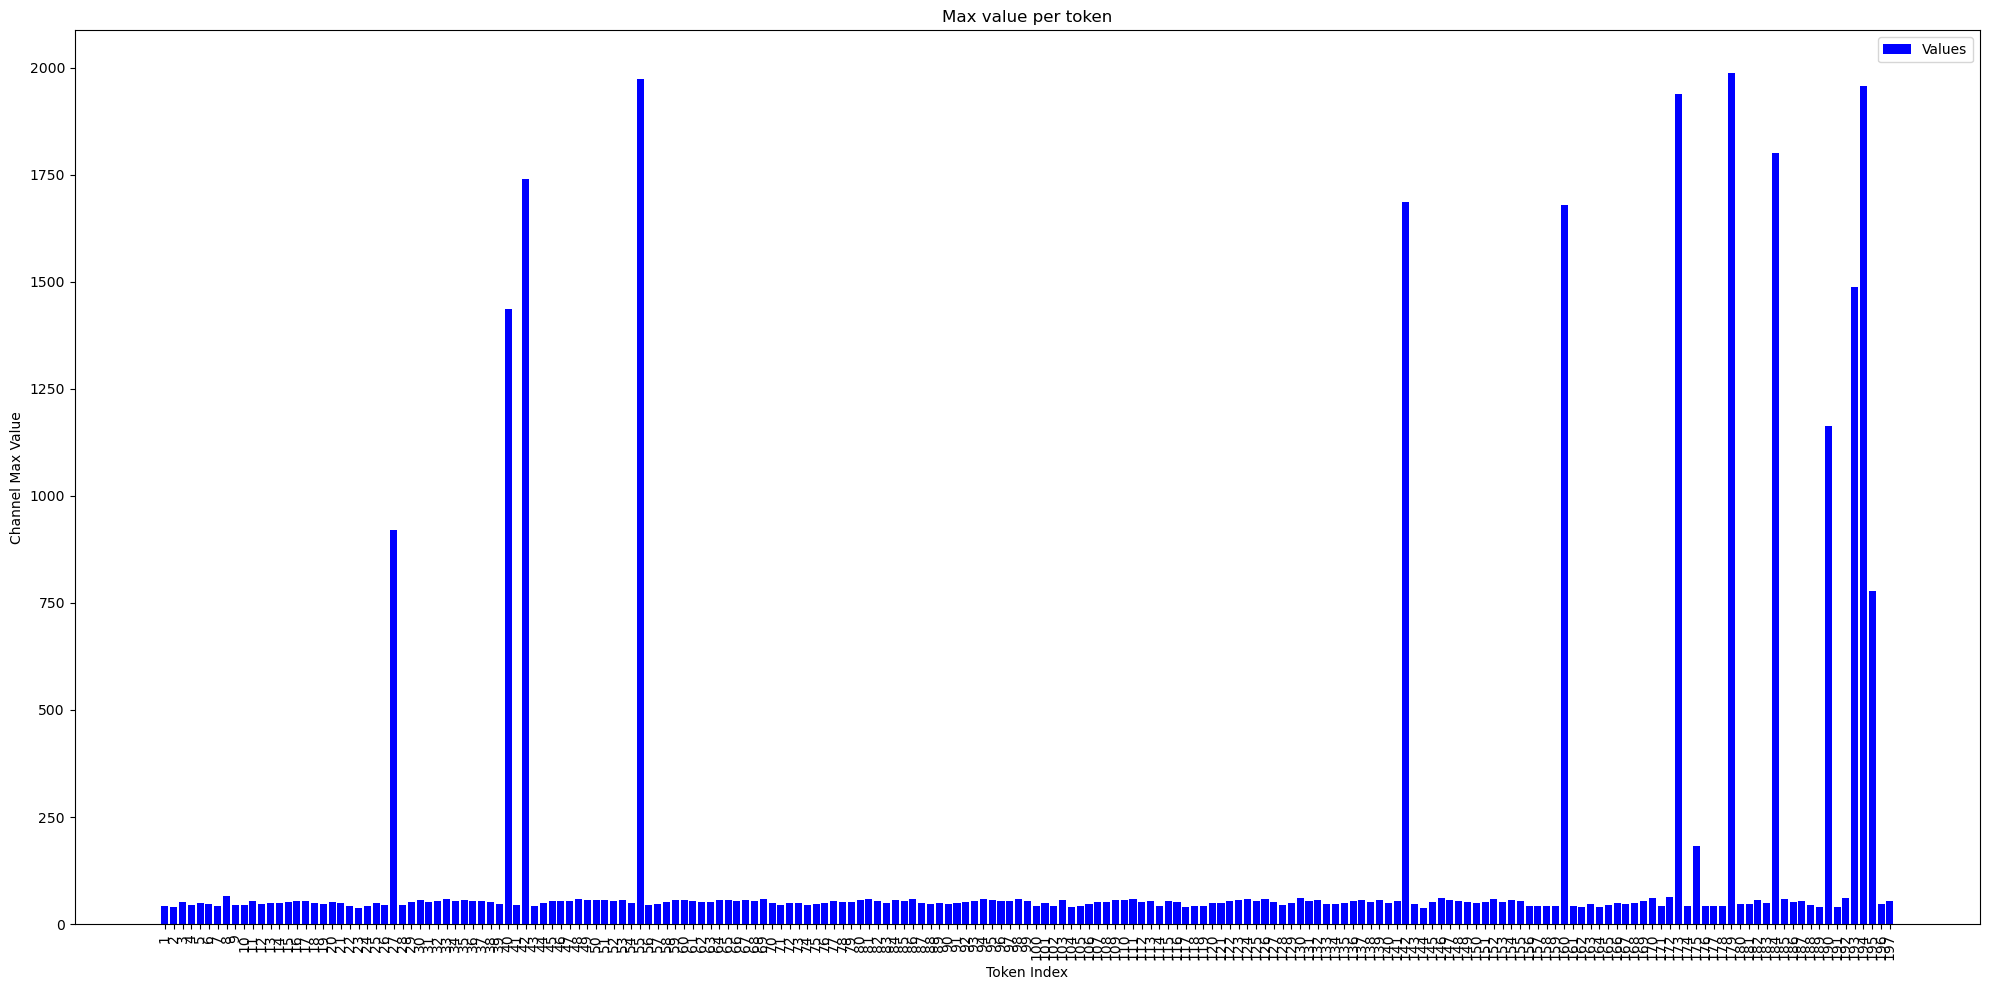

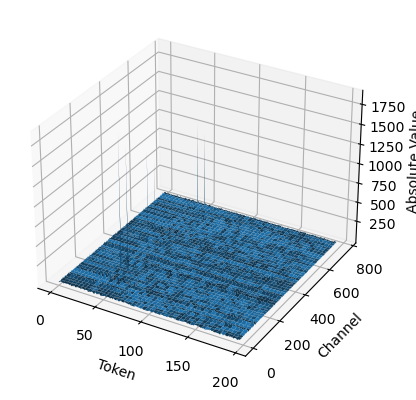

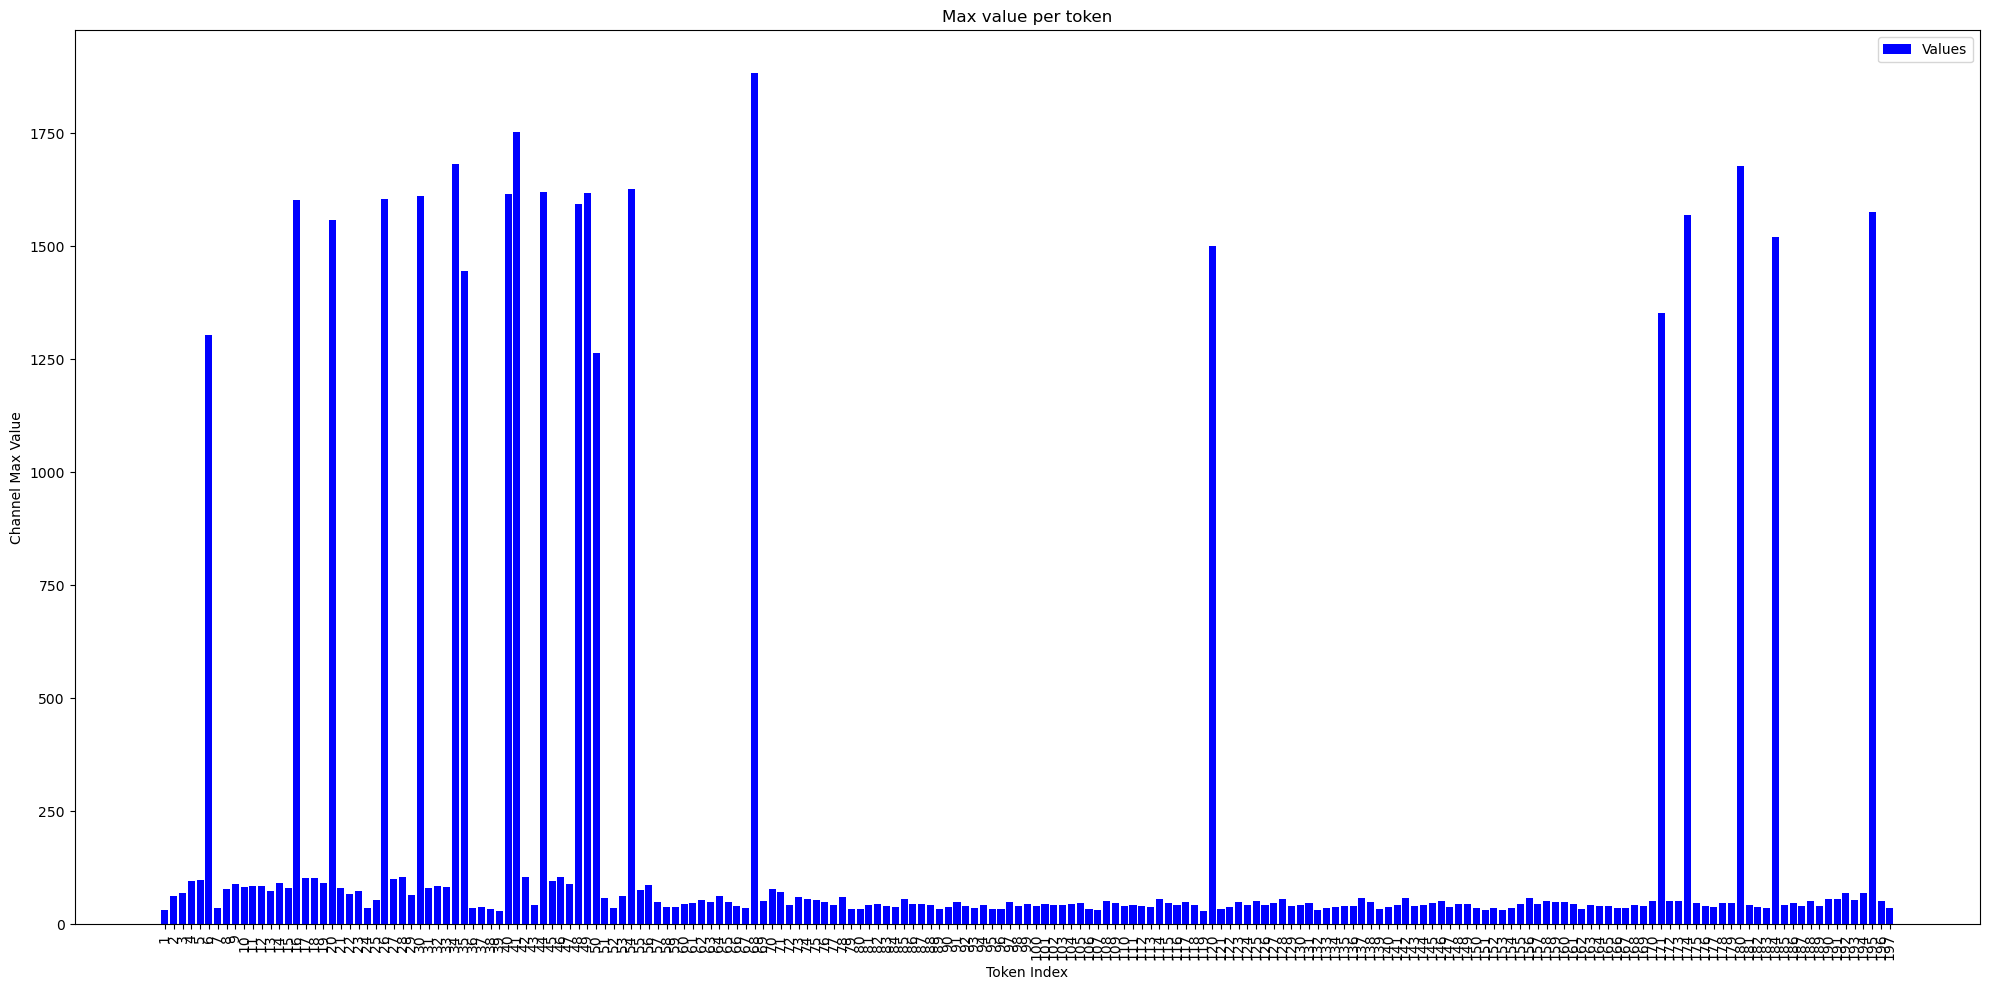

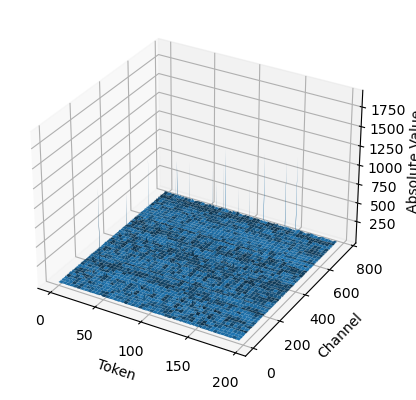

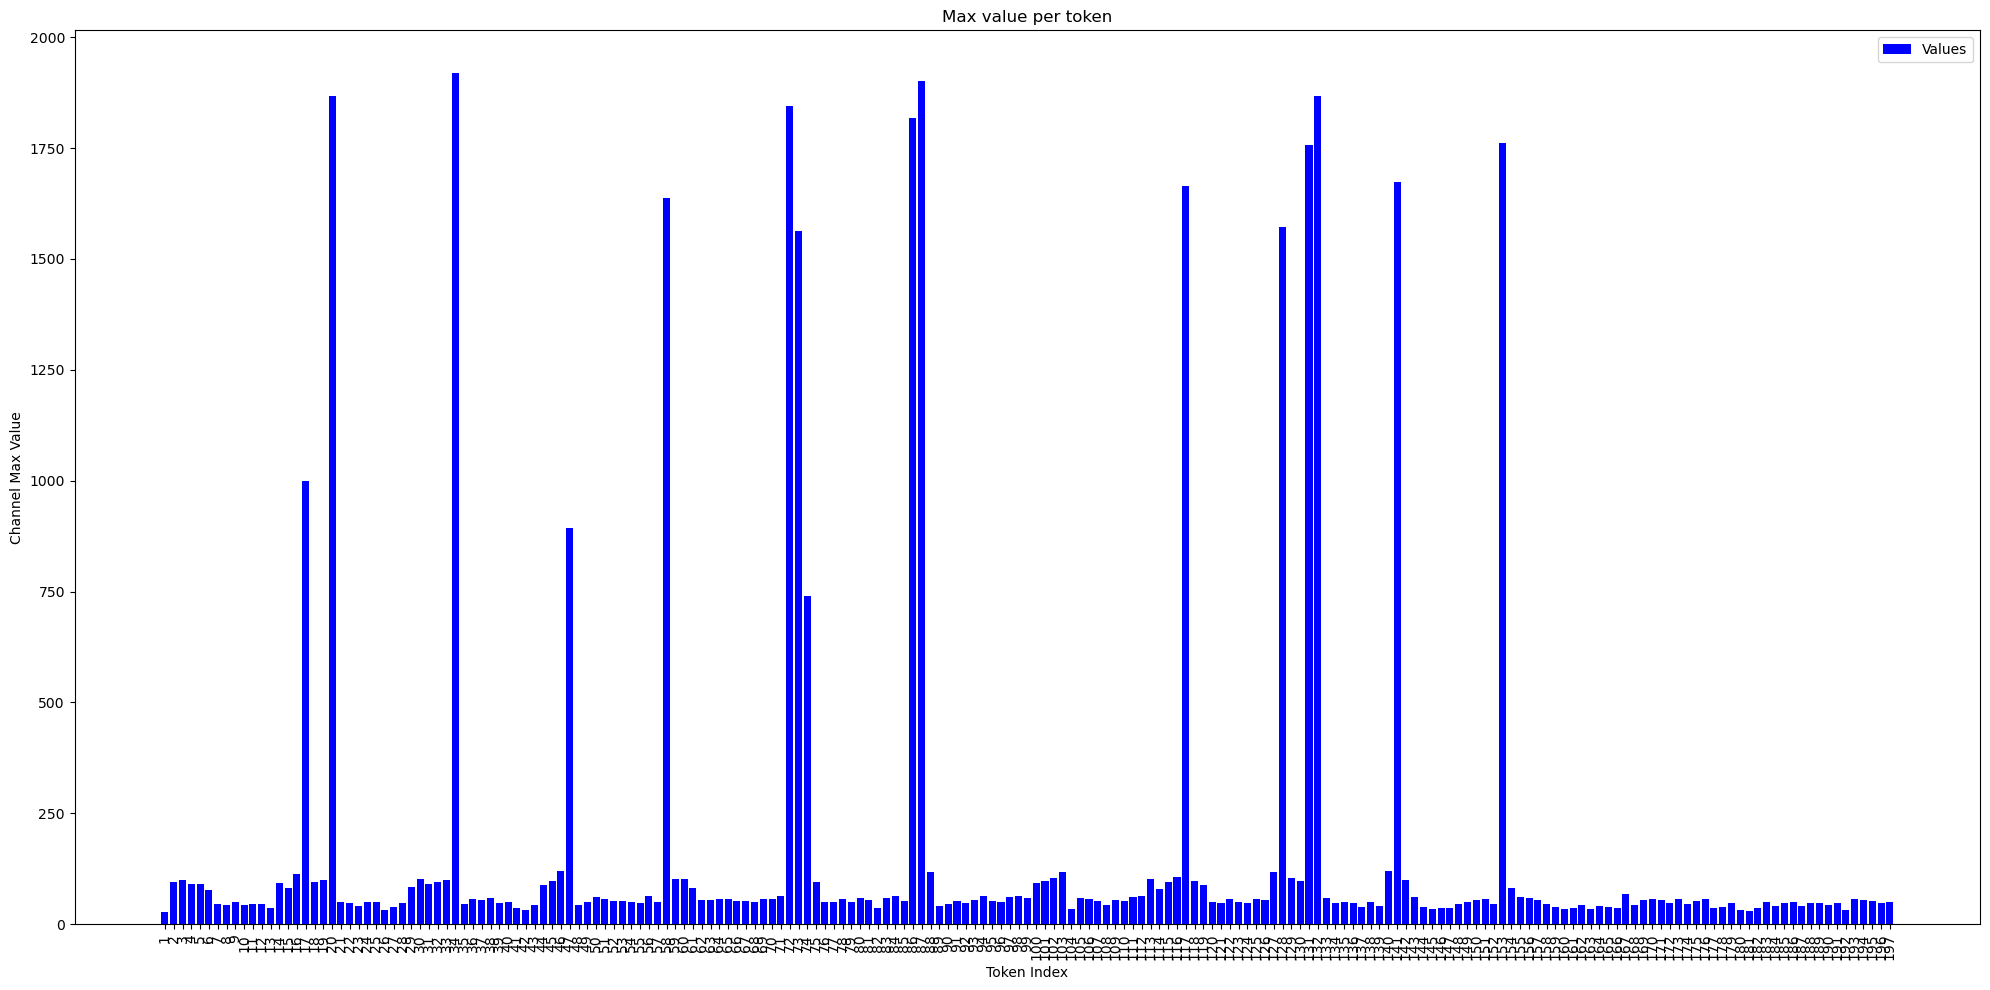

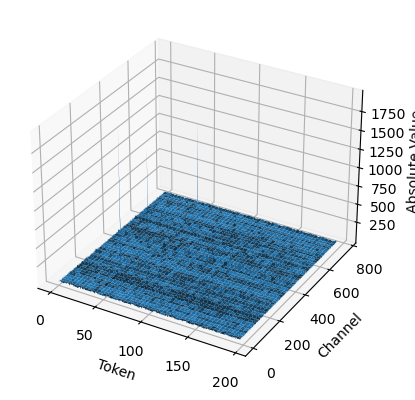

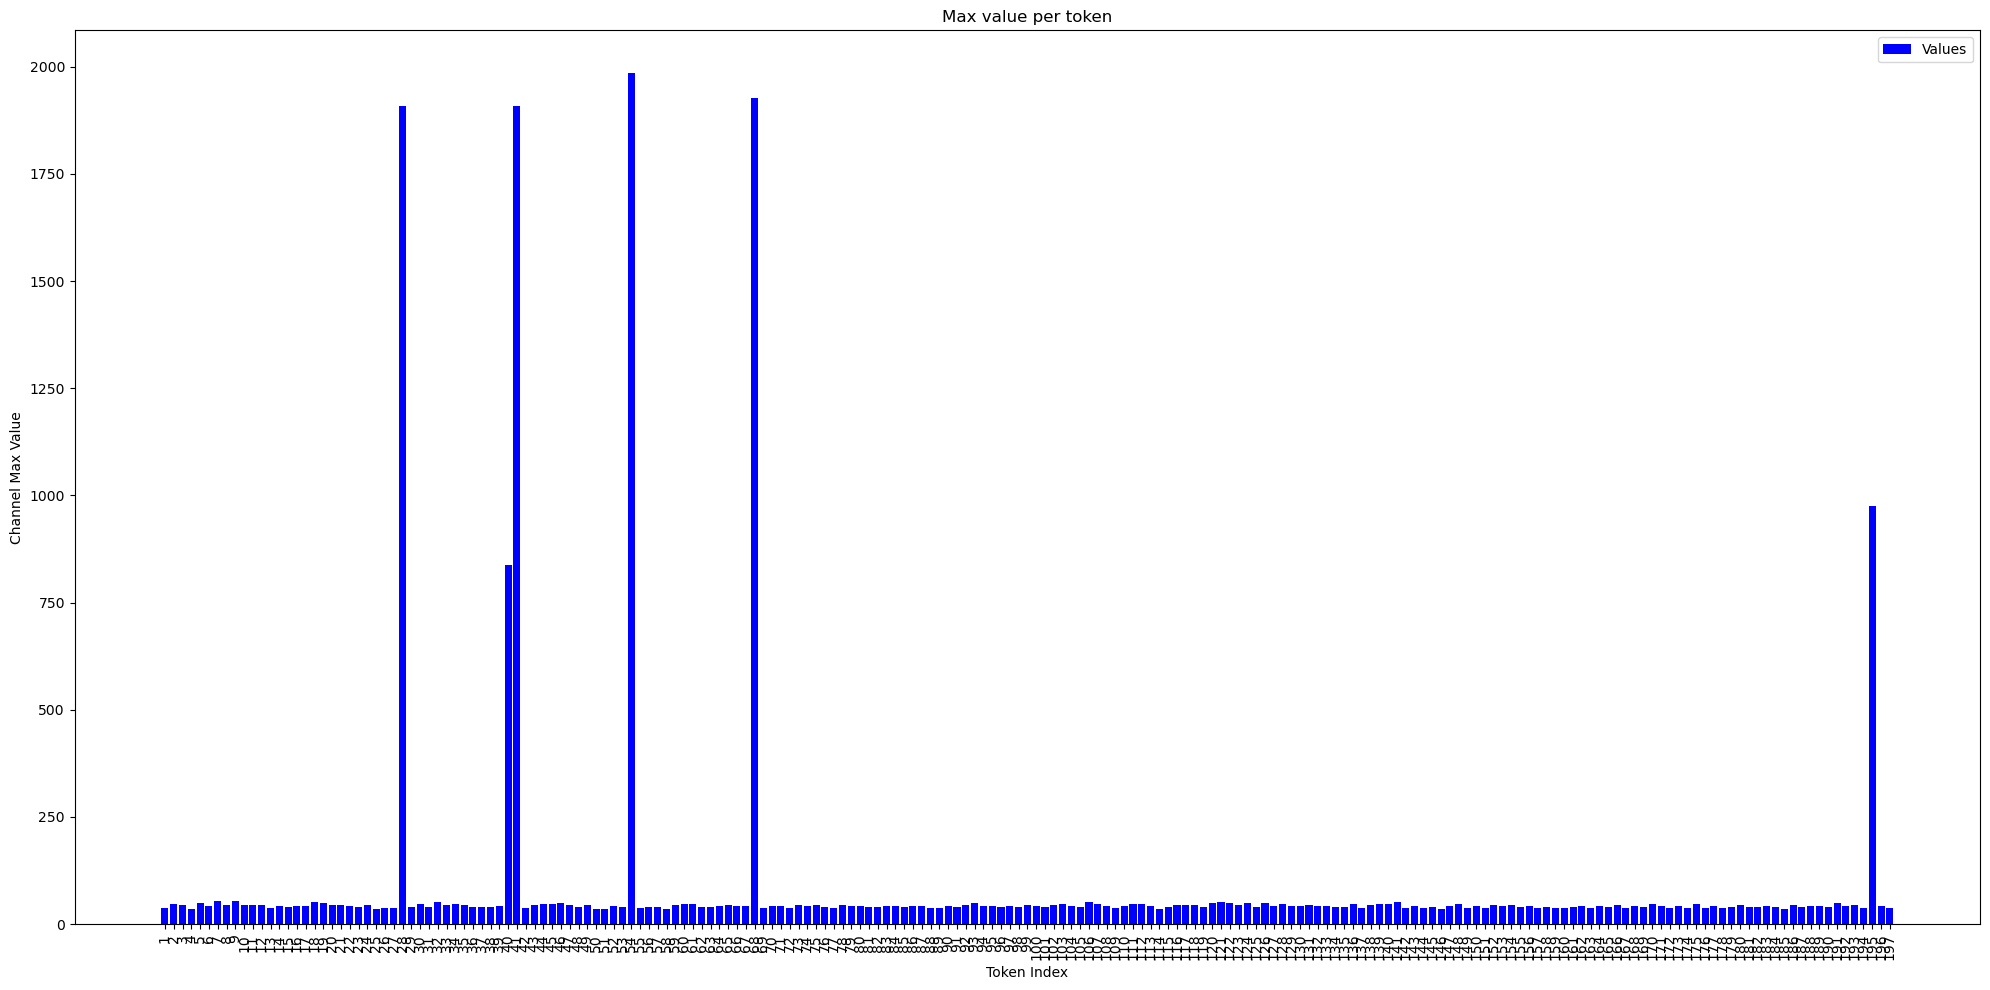

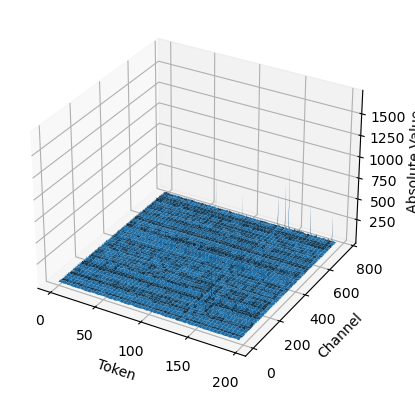

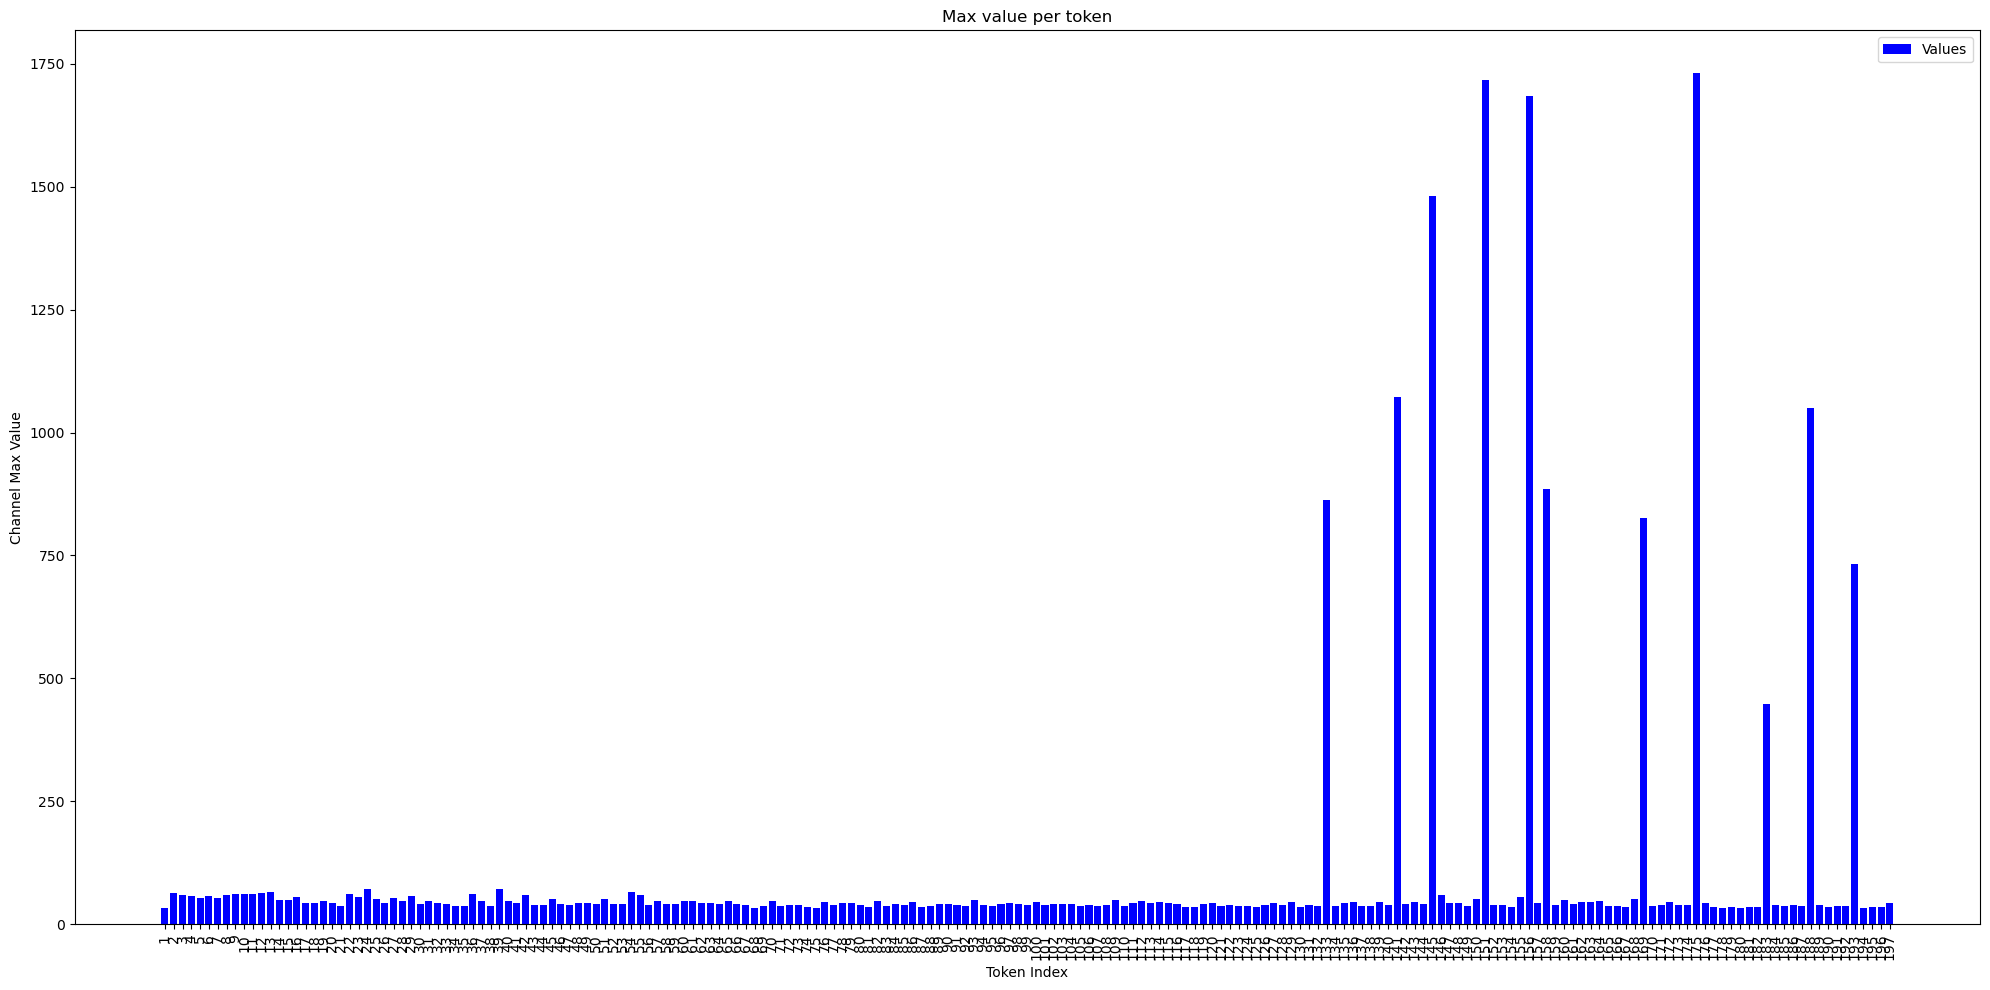

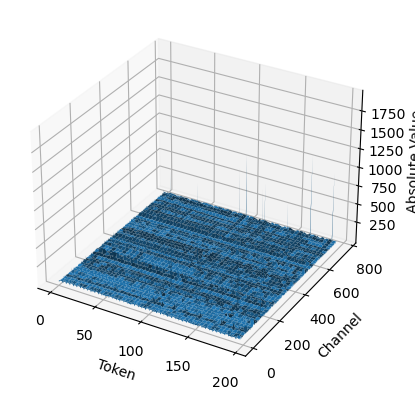

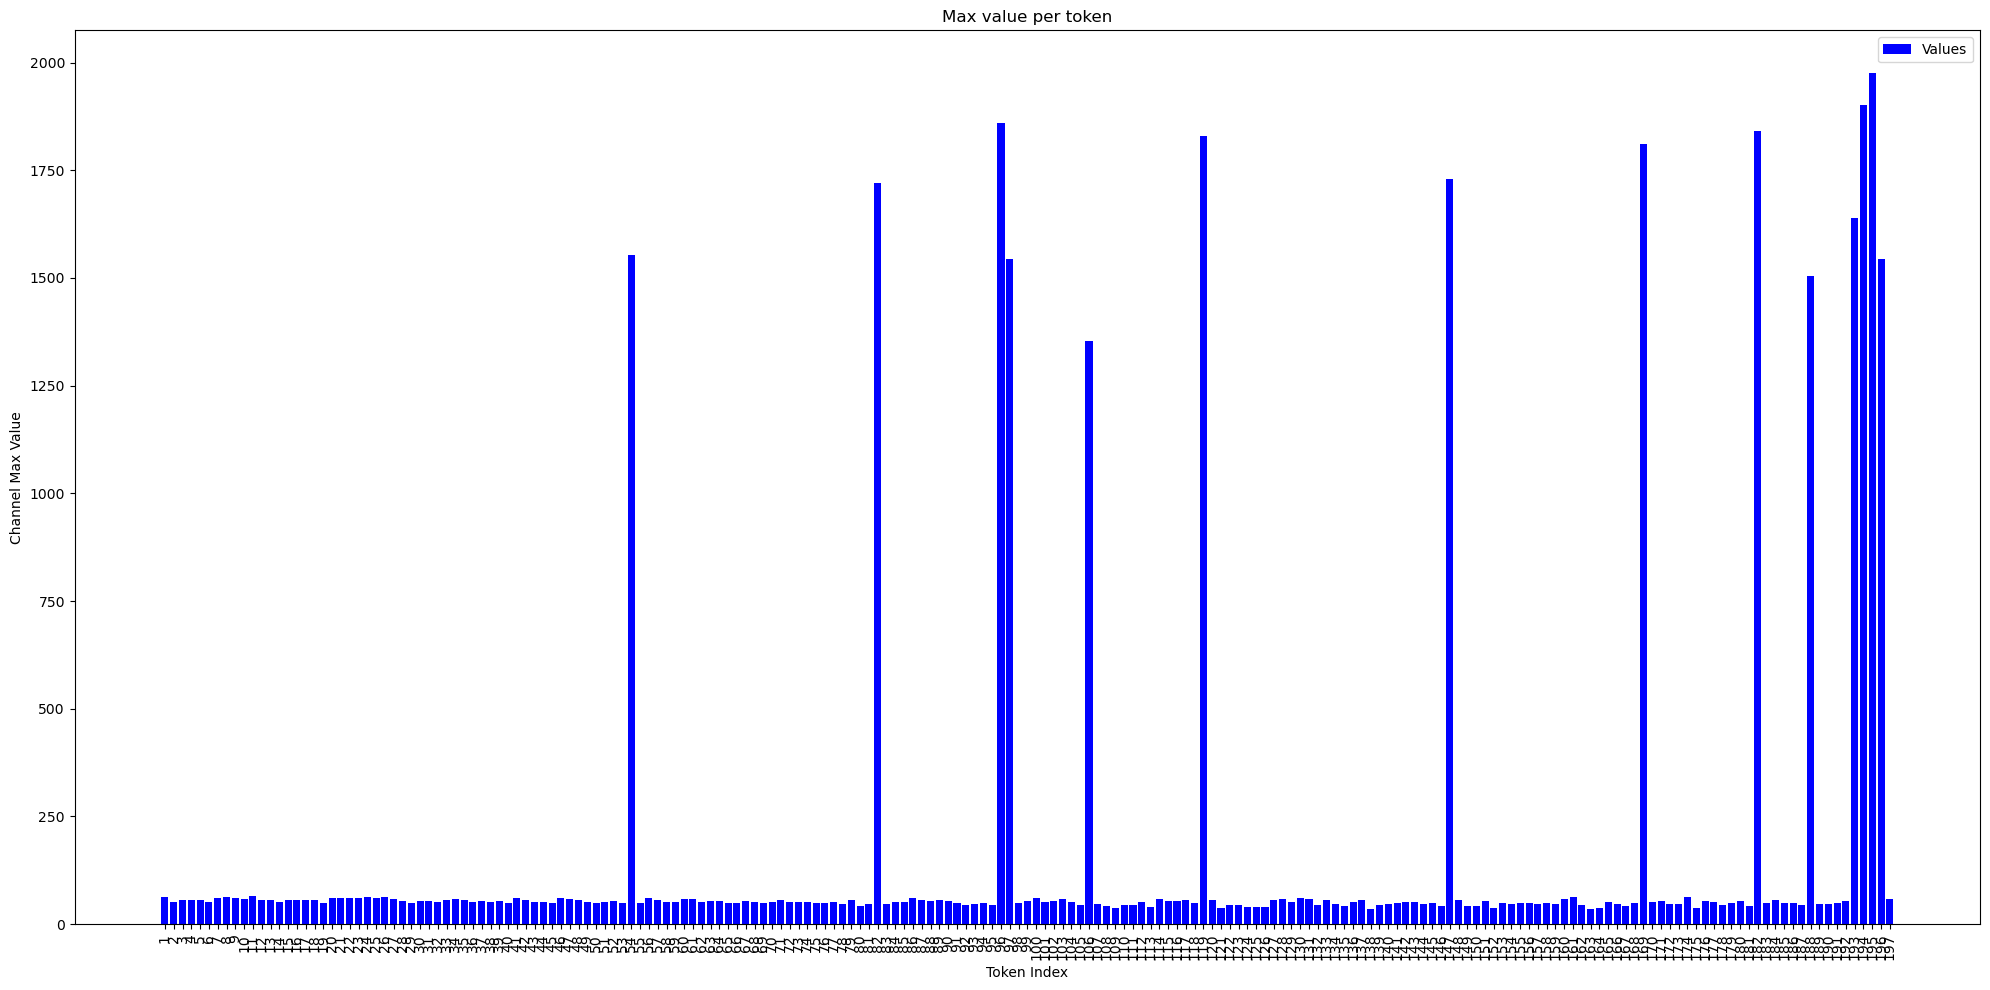

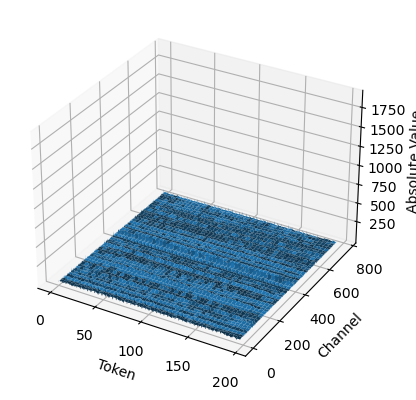

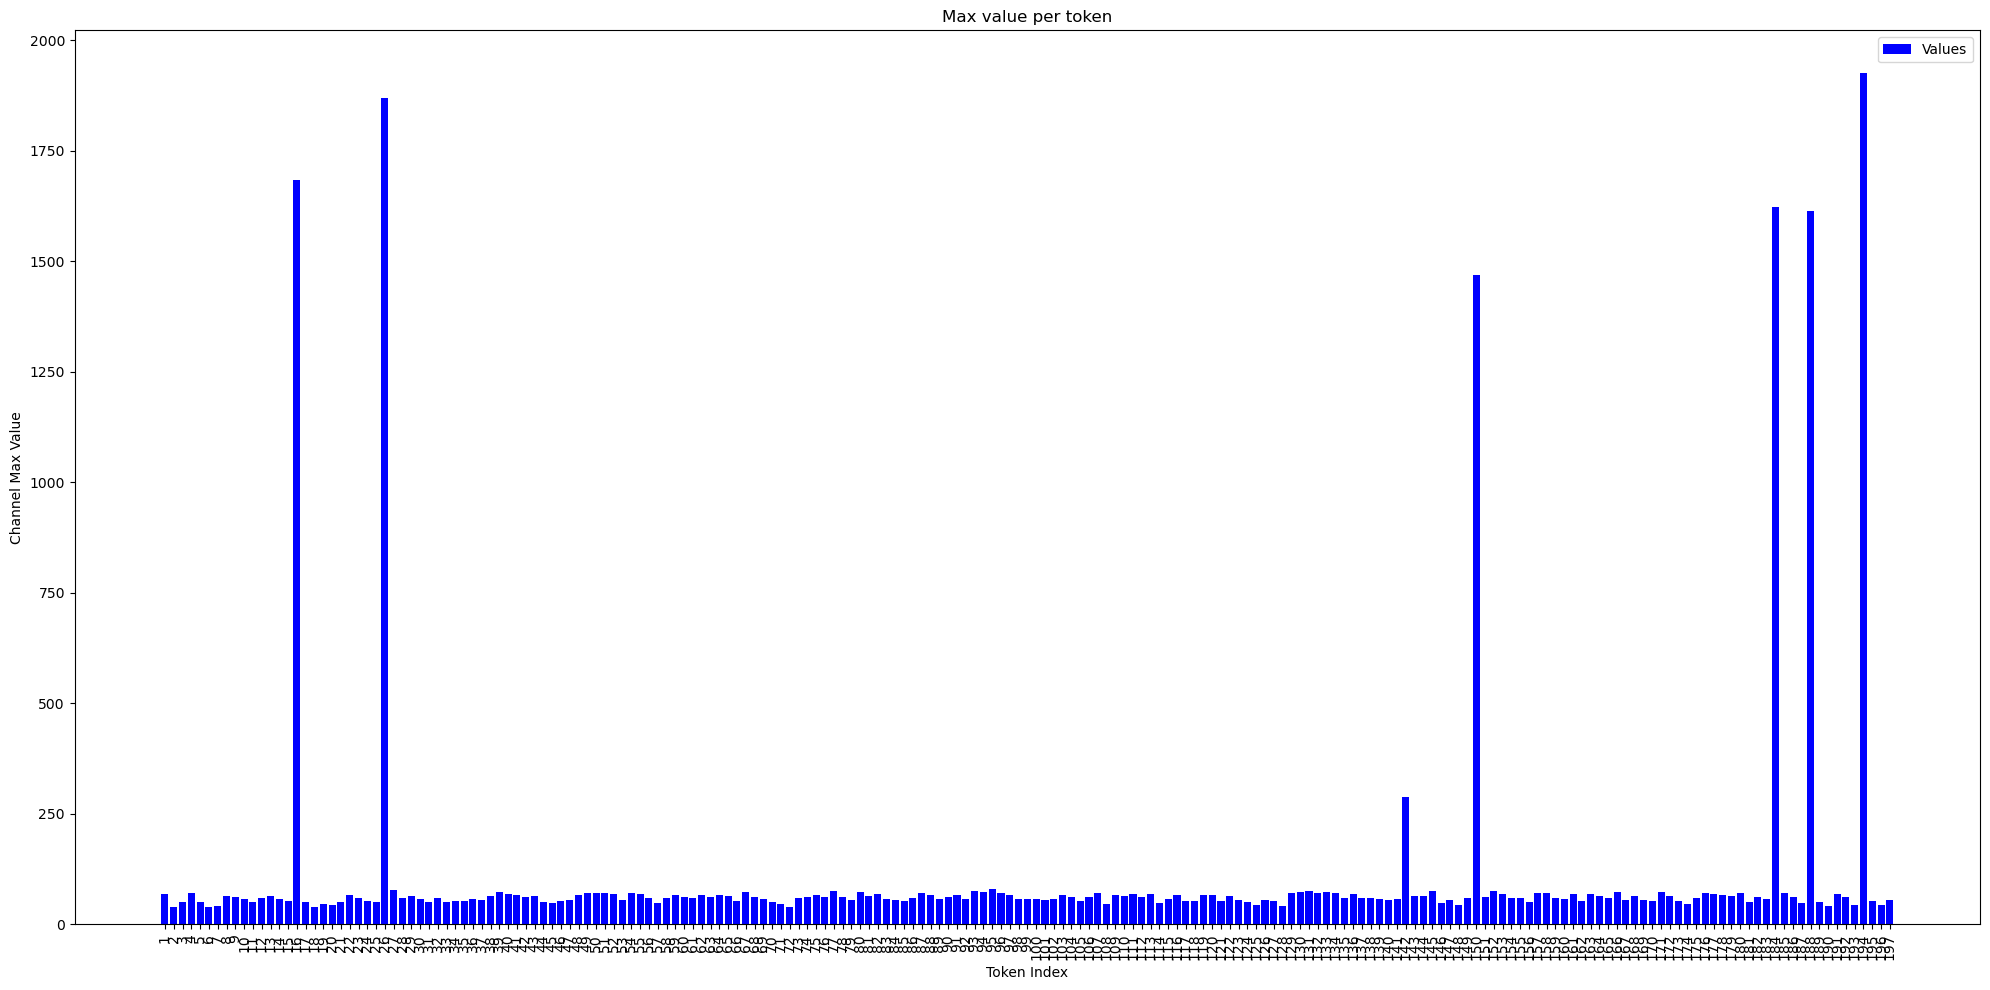

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plot을 위해 필요
import numpy as np
from z_pertensor_reproduce_fp32 import quant_vision_transformer_pertensor_wg_fp_with_qk_layernorm_CushionCache
from timm.models import create_model

###################################
# 1) 데이터 불러오기 + 전처리
###################################
def load_images_from_folder(folder_path):
    """
    folder_path 내의 모든 이미지 파일을 순회하면서 PIL Image로 불러옵니다.
    이미지가 아닌 파일이 있으면 무시하거나 예외처리할 수 있습니다.
    """
    image_files = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.JPEG')):
            image_files.append(os.path.join(folder_path, filename))
    return image_files

# 예시로 ViT에 자주 쓰는 ImageNet 전처리를 정의합니다.
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

###################################
# 2) 모델 생성 & 체크포인트 로드
###################################
def build_vit_model(model_name, nb_classes, drop, drop_path, register_num):
    model = create_model(
        model_name,
        register_num=register_num,
        num_classes=nb_classes,
        drop_rate=drop,
        drop_path_rate=drop_path,
        drop_block_rate=None,
        img_size=224,
        finetune=None,
    )
    return model

###################################
# 3) 블록 n번째 출력 (Forward Hook 활용)
###################################
class BlockOutputExtractor:
    """
    n번째 블록의 출력을 쉽게 얻어오기 위한 헬퍼 클래스.
    forward hook을 사용하여 해당 블록의 출력을 self.output에 저장합니다.
    """
    def __init__(self, model, target_block=0):
        self.target_block = target_block
        self.output = None
        
        # 1) 모델 내 모든 서브 모듈을 {이름: 모듈} dict 형태로 얻는다.
        named_dict = dict(model.named_modules())
        
        # 2) "blocks.{target_block}" 형태로 모듈 이름을 만든다.
        target_block_name = f"blocks.modules_list.{self.target_block}"  # 예: "blocks.0", "blocks.1", ...
        
        # 3) 해당 이름이 실제로 존재하는지 확인
        if target_block_name not in named_dict:
            raise ValueError(f"'{target_block_name}'라는 이름의 모듈을 찾을 수 없습니다.")
        
        # 4) 모듈을 찾아서 hook 등록
        module = named_dict[target_block_name]
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # output: (batch_size, num_tokens, embed_dim) 형태라고 가정
        self.output = output.detach()

    def close(self):
        self.hook.remove()


###################################
# 4) 텐서 후처리 & 시각화 함수
###################################
def visualize_block_output(block_output, save_prefix=None):
    """
    block_output: shape (batch_size, num_tokens, embed_dim)
    - 1) 절댓값 취하기
    - 2) 3D plot (x=토큰 index, y=채널 index, z=값)
    - 3) 채널 축 기준 max -> 2D histogram (x=토큰, y=채널 max값)
    """
    # 여기서는 배치 크기가 1이라고 가정하고 진행
    # 만약 batch_size > 1이면 적절히 loop나 indexing을 추가해주어야 합니다.
    abs_output = block_output[0].abs().cpu().numpy()  # (num_tokens, embed_dim)
    num_tokens, embed_dim = abs_output.shape

    # ----- (a) 3D plot -----
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # x,y 좌표 meshgrid 생성
    # x: token index, y: channel index
    token_idx = np.arange(num_tokens)
    channel_idx = np.arange(embed_dim)
    xx, yy = np.meshgrid(token_idx, channel_idx)

    # z 값 (절댓값)
    zz = abs_output[xx, yy]  # xx,yy shape과 동일하게 만들어서 plot

    ax.plot_surface(xx, yy, zz, cmap=None)  # color map 지정 안 함(기본값)
    ax.set_xlabel('Token')
    ax.set_ylabel('Channel')
    ax.set_zlabel('Absolute Value')
    if save_prefix:
        plt.savefig(f"{save_prefix}_3d.png")
    else:
        plt.show()

    # ----- (b) 채널축 기준 max -> Bar Chart -----
    # 각 토큰마다 채널 중 가장 큰 값
    max_per_token = abs_output.max(axis=1)  # shape = (num_tokens,)

    # num_tokens를 기준으로 막대그래프 그리기
    num_tokens = len(max_per_token)
    x_values = list(range(1, num_tokens + 1))

    plt.figure(figsize=(20, 10))
    plt.bar(x_values, max_per_token, color='blue')

    plt.xlabel("Token Index")
    plt.ylabel("Channel Max Value")
    plt.title("Max value per token")
    plt.legend(["Values"], loc='upper right')
    plt.xticks(x_values, rotation=90)

    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_bar.png")
    else:
        plt.show()


###################################
# 5) 전체 파이프라인 예시
###################################
def main():
    data_path = '/home/shkim/QT/deit/small_sample_imagenet'    # 이미지 폴더 경로
    # cp_path = '/home/shkim/QT/deit/output/finetune/vit_base_finetuning_in1k_fullprecision_for_JINO/full_precision_checkpoint-6000.pth.tar'    # 체크포인트 경로
    # cp_path = '/home/shkim/QT/deit/output/finetune/vit_base_finetuning_in1k_pertensor_int8_4register/checkpoint-6000.pth.tar'
    cp_path = '/home/shkim/QT/deit/output/finetune/vit_base_finetuning_in1k_fullprecision_for_probing/checkpoint-2501.pth.tar'
    # model_name = 'eightbits_deit_base_patch16_224'
    model_name = 'deit_base_patch16_224'
    nb_classes = 1000
    drop = 0.0
    drop_path = 0.1
    register_num = 0

    device = 'cpu'
    target_block = 11  # n번째 블록(output을 뽑고 싶은 블록 인덱스)

    # 1) 데이터 로드
    image_paths = load_images_from_folder(data_path)

    # 2) 모델 생성 & 체크포인트 로드
    model = build_vit_model(model_name, nb_classes, drop, drop_path, register_num)
    checkpoint = torch.load(cp_path, map_location='cpu')
    print(checkpoint['state_dict'].keys())
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    model.to(device)

    # 3) Hook 설정
    extractor = BlockOutputExtractor(model, target_block=target_block)

    # 4) 데이터 루프
    for idx, img_path in enumerate(image_paths):
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)  # (1, 3, 224, 224)

        with torch.no_grad():
            _ = model(img_tensor)  # forward -> hook에서 block_output 저장

        block_out = extractor.output  # shape = (1, num_tokens, embed_dim)
        if block_out is None:
            print(f"[ERROR] Block output is None for image: {img_path}")
            continue

        # 5) 텐서 후처리 및 시각화
        # 파일 이름이나 인덱스를 prefix로 하여 그래프 저장 가능
        save_prefix = f"./visualization_result/vit_base_finetuning_in1k_pertensor_int8_4register/result_{idx}"
        # save_prefix = None
        visualize_block_output(block_out, save_prefix=save_prefix)

    # hook 제거
    extractor.close()

if __name__ == "__main__":
    main()


In [10]:
import os
sampleData_path = '/home/shkim/ViT_zip/sampled_imagenet/one_sample_per_class'

jpeg_count = sum(1 for f in os.listdir(sampleData_path) if f.lower().endswith(('.jpg', '.jpeg')))
print("Number of JPEG files:", jpeg_count)

Number of JPEG files: 1000


In [9]:
import os
import shutil
import random

# 원본 데이터셋 경로 (각 클래스 폴더가 존재)
source_root = "/data/ILSVRC2012/val"

# 저장할 대상 경로
target_root = "/home/shkim/ViT_zip/sampled_imagenet/one_sample_per_class"

# 대상 폴더가 없으면 생성
os.makedirs(target_root, exist_ok=True)

# 각 클래스 폴더에서 랜덤한 이미지 하나씩 선택
for class_name in os.listdir(source_root):
    class_path = os.path.join(source_root, class_name)

    # 클래스 폴더인지 확인
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg'))]

        # 해당 클래스에 이미지가 존재하는지 확인
        if image_files:
            random_image = random.choice(image_files)  # 랜덤으로 하나 선택
            source_image_path = os.path.join(class_path, random_image)
            target_image_path = os.path.join(target_root, f"{class_name}_{random_image}")  # 중복 방지를 위해 클래스 이름 추가

            # 이미지 복사
            shutil.copy2(source_image_path, target_image_path)
            print(f"Copied: {source_image_path} -> {target_image_path}")

print("✅ 모든 클래스에서 랜덤한 이미지 하나씩 복사 완료!")


Copied: /data/ILSVRC2012/val/n02128757/ILSVRC2012_val_00042484.JPEG -> /home/shkim/ViT_zip/sampled_imagenet/one_sample_per_class/n02128757_ILSVRC2012_val_00042484.JPEG
Copied: /data/ILSVRC2012/val/n02790996/ILSVRC2012_val_00014671.JPEG -> /home/shkim/ViT_zip/sampled_imagenet/one_sample_per_class/n02790996_ILSVRC2012_val_00014671.JPEG
Copied: /data/ILSVRC2012/val/n03125729/ILSVRC2012_val_00008716.JPEG -> /home/shkim/ViT_zip/sampled_imagenet/one_sample_per_class/n03125729_ILSVRC2012_val_00008716.JPEG
Copied: /data/ILSVRC2012/val/n03743016/ILSVRC2012_val_00008833.JPEG -> /home/shkim/ViT_zip/sampled_imagenet/one_sample_per_class/n03743016_ILSVRC2012_val_00008833.JPEG
Copied: /data/ILSVRC2012/val/n02787622/ILSVRC2012_val_00039991.JPEG -> /home/shkim/ViT_zip/sampled_imagenet/one_sample_per_class/n02787622_ILSVRC2012_val_00039991.JPEG
Copied: /data/ILSVRC2012/val/n03733805/ILSVRC2012_val_00011426.JPEG -> /home/shkim/ViT_zip/sampled_imagenet/one_sample_per_class/n03733805_ILSVRC2012_val_000114